In [1]:
# Import packages

import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import io

auth = ('FDS_DEMO_EUR_464603_SERVICES', '6hc85SGcgWCrkbJo')

In [2]:
## Define the names of factors that you are interested and enter their corresponding screening formulas

qfl_data = pd.read_excel('QFL.xlsx', header = 1)

qfl_data = qfl_data.drop(['Unnamed: 0'], axis = 1)

qfl_data.head()

,Factor Group,Field ID,Field Name,FactSet Screening Formula,Data Source,Unnamed: 6,Currency,Shares,CACCESS,Search Keywords,Data Type,String Length
0,Asset Data,DAYS_SINCE_RPT,Days Since Report,QFL_DAYS_SINCE_RPT(0),FactSet Estimates,"'Days Since Report': 'QFL_DAYS_SINCE_RPT(0)',",None,0,00QFL,"asset,data,estimates",INTEGER,NaN
1,Asset Data,DAYS_TO_RPT,Days to Report,QFL_DAYS_TO_RPT(0),FactSet Estimates,"'Days to Report': 'QFL_DAYS_TO_RPT(0)',",None,0,00QFL,"asset,data,estimates",INTEGER,NaN
2,Asset Data,ADR_FLAG,ADR Flag,QFL_ADR_FLAG(0),FactSet Reference Data,"'ADR Flag': 'QFL_ADR_FLAG(0)',",None,0,00QFL,"asset,reference,data",INTEGER,NaN
3,Asset Data,BANKRUPTCY,Bankruptcy Flag,QFL_BANKRUPTCY(0),FactSet Reference Data,"'Bankruptcy Flag': 'QFL_BANKRUPTCY(0)',",None,0,00QFL,"asset,reference,data",INTEGER,NaN
4,Asset Data,PRIMARY_LIST,Primary Listing,QFL_PRIMARY_LIST(0),FactSet Reference Data,"'Primary Listing': 'QFL_PRIMARY_LIST(0)',",None,0,00QFL,"asset,reference,data",INTEGER,NaN


In [3]:
# create QFL factor categories dictionary: Key = Field Name, Values = FactSet Screening Formula

qfl_categories = qfl_data['Factor Group'].unique()
qfl_categories = list(np.delete(qfl_categories, [0,1,2]))

for i in qfl_categories:
    globals()['qfl_{0}'.format(i).lower()] = dict(qfl_data[qfl_data['Factor Group'] == i][['FactSet Screening Formula', 'FactSet Screening Formula']].values)

qfl_categories

['Size',
 'Value',
 'Growth',
 'Profitability',
 'Efficiency',
 'Solvency',
 'Management',
 'Quality',
 'Analyst Sentiment',
 'Crowding',
 'Insider Activity',
 'Corporate Governance',
 'Momentum',
 'Volatility',
 'Market Sensitivity',
 'Technical',
 'Liquidity']

In [4]:
qfl_factors = qfl_growth # change QFL Category here!

formulas = list(qfl_factors.values())
columns = list(qfl_factors.keys())

In [5]:
# Define Universe & QFL parameters

endpoint = "https://datadirect.factset.com/services/FastFetch?"
factlet = "ExtractBenchmarkDetail"

ids = "890100"
date = "11/30/2020"
fwd_date = "12/31/2020"

# Forward Returns, Size Class, Security Market Value (USD)

params = ['P_TOTAL_RETURN(' + str(date) + ',' + str(fwd_date) + ')',
          'QFL_SIZE_CLASS(' + str(date) + ')',
          'QFL_MKT_VAL_SEC(' + str(date) + ')']

items = 'PROPER_NAME, FG_GICS_SECTOR, PROPER(FG_COUNTRY)'

items_call = items + ',' + ','.join([str(elem) for elem in params]) + ',' + ','.join([str(qfl_elem) for qfl_elem in list(qfl_factors.values())])

# cutoff = "10"
output_format = "pipe"
showTitle = "N"
showHeader = "N"
showDataType = "N"

response = requests.post(endpoint, auth=auth, data = {'factlet':factlet, 
                                                      'ids':ids, 
                                                      'items': items_call,
                                                      'dates':date, 
                                                      # 'cutoff':cutoff,
                                                      'format':output_format,
                                                      'showTitle':showTitle,
                                                      'showHeader':showHeader,
                                                      'showDataType':showDataType})

df = pd.read_csv(io.StringIO(response.text), sep = '|')

In [6]:
col_universe = ['BENCHMARK_ID', 'DATE', 'SECURITY_ID', 'Weight', 'proper_name',
       'fg_gics_sector', 'proper', 'p_total_return', 'qfl_size_class', 'qfl_mkt_val_sec']
items_call_pipe = '|'.join([str(qfl_elem) for qfl_elem in list(qfl_factors.values())])
columns_name = col_universe + items_call_pipe.split('|')
df.columns = pd.Index(columns_name)

In [7]:
qfl_df = df

In [8]:
qfl_df.head()

,BENCHMARK_ID,DATE,SECURITY_ID,Weight,proper_name,fg_gics_sector,proper,p_total_return,qfl_size_class,qfl_mkt_val_sec,"QFL_MKT_SHR_GR(0,ECON,LT)","QFL_MKT_SHR_GR(0,ECON,5YR)","QFL_MKT_SHR_GR(0,ECON,4YR)","QFL_MKT_SHR_GR(0,ECON,3YR)","QFL_MKT_SHR_GR(0,ECON,2YR)","QFL_MKT_SHR_GR(0,ECON,1YR)","QFL_MKT_SHR_GR(0,ECON,5YR_FWD)","QFL_MKT_SHR_GR(0,ECON,4YR_FWD)","QFL_MKT_SHR_GR(0,ECON,3YR_FWD)","QFL_MKT_SHR_GR(0,ECON,2YR_FWD)","QFL_MKT_SHR_GR(0,ECON,1YR_FWD)","QFL_MKT_SHR_GR(0,SECT,LT)","QFL_MKT_SHR_GR(0,SECT,5YR)","QFL_MKT_SHR_GR(0,SECT,4YR)","QFL_MKT_SHR_GR(0,SECT,3YR)","QFL_MKT_SHR_GR(0,SECT,2YR)","QFL_MKT_SHR_GR(0,SECT,1YR)","QFL_MKT_SHR_GR(0,SECT,5YR_FWD)","QFL_MKT_SHR_GR(0,SECT,4YR_FWD)","QFL_MKT_SHR_GR(0,SECT,3YR_FWD)","QFL_MKT_SHR_GR(0,SECT,2YR_FWD)","QFL_MKT_SHR_GR(0,SECT,1YR_FWD)","QFL_MKT_SHR_GR(0,SUBSECT,LT)","QFL_MKT_SHR_GR(0,SUBSECT,5YR)","QFL_MKT_SHR_GR(0,SUBSECT,4YR)","QFL_MKT_SHR_GR(0,SUBSECT,3YR)","QFL_MKT_SHR_GR(0,SUBSECT,2YR)","QFL_MKT_SHR_GR(0,SUBSECT,1YR)","QFL_MKT_SHR_GR(0,SUBSECT,5YR_FWD)","QFL_MKT_SHR_GR(0,SUBSECT,4YR_FWD)","QFL_MKT_SHR_GR(0,SUBSECT,3YR_FWD)","QFL_MKT_SHR_GR(0,SUBSECT,2YR_FWD)","QFL_MKT_SHR_GR(0,SUBSECT,1YR_FWD)","QFL_MKT_SHR_GR(0,INDGRP,LT)","QFL_MKT_SHR_GR(0,INDGRP,5YR)","QFL_MKT_SHR_GR(0,INDGRP,4YR)","QFL_MKT_SHR_GR(0,INDGRP,3YR)","QFL_MKT_SHR_GR(0,INDGRP,2YR)","QFL_MKT_SHR_GR(0,INDGRP,1YR)","QFL_MKT_SHR_GR(0,INDGRP,5YR_FWD)","QFL_MKT_SHR_GR(0,INDGRP,4YR_FWD)","QFL_MKT_SHR_GR(0,INDGRP,3YR_FWD)","QFL_MKT_SHR_GR(0,INDGRP,2YR_FWD)","QFL_MKT_SHR_GR(0,INDGRP,1YR_FWD)","QFL_SALES_GR(0,LT)","QFL_SALES_GR(0,5YR)","QFL_SALES_GR(0,4YR)","QFL_SALES_GR(0,3YR)","QFL_SALES_GR(0,2YR)","QFL_SALES_GR(0,1YR)","QFL_SALES_GR(0,5YR_FWD)","QFL_SALES_GR(0,4YR_FWD)","QFL_SALES_GR(0,3YR_FWD)","QFL_SALES_GR(0,2YR_FWD)","QFL_SALES_GR(0,1YR_FWD)","QFL_EBIT_GR(0,LT)","QFL_EBIT_GR(0,5YR)","QFL_EBIT_GR(0,4YR)","QFL_EBIT_GR(0,3YR)","QFL_EBIT_GR(0,2YR)","QFL_EBIT_GR(0,1YR)","QFL_EBIT_GR(0,5YR_FWD)","QFL_EBIT_GR(0,4YR_FWD)","QFL_EBIT_GR(0,3YR_FWD)","QFL_EBIT_GR(0,2YR_FWD)","QFL_EBIT_GR(0,1YR_FWD)","QFL_EBITDA_GR(0,LT)","QFL_EBITDA_GR(0,5YR)","QFL_EBITDA_GR(0,4YR)","QFL_EBITDA_GR(0,3YR)","QFL_EBITDA_GR(0,2YR)","QFL_EBITDA_GR(0,1YR)","QFL_EBITDA_GR(0,5YR_FWD)","QFL_EBITDA_GR(0,4YR_FWD)","QFL_EBITDA_GR(0,3YR_FWD)","QFL_EBITDA_GR(0,2YR_FWD)","QFL_EBITDA_GR(0,1YR_FWD)","QFL_NET_INC_GR(0,LT)","QFL_NET_INC_GR(0,5YR)","QFL_NET_INC_GR(0,4YR)","QFL_NET_INC_GR(0,3YR)","QFL_NET_INC_GR(0,2YR)","QFL_NET_INC_GR(0,1YR)","QFL_NET_INC_GR(0,5YR_FWD)","QFL_NET_INC_GR(0,4YR_FWD)","QFL_NET_INC_GR(0,3YR_FWD)","QFL_NET_INC_GR(0,2YR_FWD)","QFL_NET_INC_GR(0,1YR_FWD)","QFL_EPS_GR(0,LT)","QFL_EPS_GR(0,5YR)","QFL_EPS_GR(0,4YR)","QFL_EPS_GR(0,3YR)","QFL_EPS_GR(0,2YR)","QFL_EPS_GR(0,1YR)","QFL_EPS_GR(0,5YR_FWD)","QFL_EPS_GR(0,4YR_FWD)","QFL_EPS_GR(0,3YR_FWD)","QFL_EPS_GR(0,2YR_FWD)","QFL_EPS_GR(0,1YR_FWD)","QFL_OCF_GR(0,LT)","QFL_OCF_GR(0,5YR)","QFL_OCF_GR(0,4YR)","QFL_OCF_GR(0,3YR)","QFL_OCF_GR(0,2YR)","QFL_OCF_GR(0,1YR)","QFL_OCF_GR(0,5YR_FWD)","QFL_OCF_GR(0,4YR_FWD)","QFL_OCF_GR(0,3YR_FWD)","QFL_OCF_GR(0,2YR_FWD)","QFL_OCF_GR(0,1YR_FWD)","QFL_FCF_GR(0,LT)","QFL_FCF_GR(0,5YR)","QFL_FCF_GR(0,4YR)","QFL_FCF_GR(0,3YR)","QFL_FCF_GR(0,2YR)","QFL_FCF_GR(0,1YR)","QFL_FCF_GR(0,5YR_FWD)","QFL_FCF_GR(0,4YR_FWD)","QFL_FCF_GR(0,3YR_FWD)","QFL_FCF_GR(0,2YR_FWD)","QFL_FCF_GR(0,1YR_FWD)","QFL_DPS_GR(0,LT)","QFL_DPS_GR(0,5YR)","QFL_DPS_GR(0,4YR)","QFL_DPS_GR(0,3YR)","QFL_DPS_GR(0,2YR)","QFL_DPS_GR(0,1YR)","QFL_DPS_GR(0,5YR_FWD)","QFL_DPS_GR(0,4YR_FWD)","QFL_DPS_GR(0,3YR_FWD)","QFL_DPS_GR(0,2YR_FWD)","QFL_DPS_GR(0,1YR_FWD)",QFL_LTG(0),QFL_STABLE_SALES_GR(0),QFL_STABLE_EBIT_GR(0),QFL_STABLE_EBITDA_GR(0),QFL_STABLE_NET_INC_GR(0),QFL_STABLE_EPS_GR(0),QFL_STABLE_OCF_GR(0),QFL_STABLE_FCF_GR(0),QFL_STABLE_DPS_GR(0),"QFL_RD_SALES(0,CT)","QFL_RD_SALES(0,NTM)","QFL_RD_SALES(0,FY1)","QFL_RD_SALES(0,FY2)","QFL_RD_BV(0,CT)","QFL_RD_BV(0,FY1)","QFL_RD_BV(0,FY2)","QFL_RD_MV(0,CT)","QFL_RD_MV(0,NTM)","QFL_RD_MV(0,FY1)","QFL_RD_MV(0,FY2)","QFL_CFI_SALES(0,CT)","QFL_CFI_SALES(0,NTM)","

In [9]:
qfl_df.tail()

,BENCHMARK_ID,DATE,SECURITY_ID,Weight,proper_name,fg_gics_sector,proper,p_total_return,qfl_size_class,qfl_mkt_val_sec,"QFL_MKT_SHR_GR(0,ECON,LT)","QFL_MKT_SHR_GR(0,ECON,5YR)","QFL_MKT_SHR_GR(0,ECON,4YR)","QFL_MKT_SHR_GR(0,ECON,3YR)","QFL_MKT_SHR_GR(0,ECON,2YR)","QFL_MKT_SHR_GR(0,ECON,1YR)","QFL_MKT_SHR_GR(0,ECON,5YR_FWD)","QFL_MKT_SHR_GR(0,ECON,4YR_FWD)","QFL_MKT_SHR_GR(0,ECON,3YR_FWD)","QFL_MKT_SHR_GR(0,ECON,2YR_FWD)","QFL_MKT_SHR_GR(0,ECON,1YR_FWD)","QFL_MKT_SHR_GR(0,SECT,LT)","QFL_MKT_SHR_GR(0,SECT,5YR)","QFL_MKT_SHR_GR(0,SECT,4YR)","QFL_MKT_SHR_GR(0,SECT,3YR)","QFL_MKT_SHR_GR(0,SECT,2YR)","QFL_MKT_SHR_GR(0,SECT,1YR)","QFL_MKT_SHR_GR(0,SECT,5YR_FWD)","QFL_MKT_SHR_GR(0,SECT,4YR_FWD)","QFL_MKT_SHR_GR(0,SECT,3YR_FWD)","QFL_MKT_SHR_GR(0,SECT,2YR_FWD)","QFL_MKT_SHR_GR(0,SECT,1YR_FWD)","QFL_MKT_SHR_GR(0,SUBSECT,LT)","QFL_MKT_SHR_GR(0,SUBSECT,5YR)","QFL_MKT_SHR_GR(0,SUBSECT,4YR)","QFL_MKT_SHR_GR(0,SUBSECT,3YR)","QFL_MKT_SHR_GR(0,SUBSECT,2YR)","QFL_MKT_SHR_GR(0,SUBSECT,1YR)","QFL_MKT_SHR_GR(0,SUBSECT,5YR_FWD)","QFL_MKT_SHR_GR(0,SUBSECT,4YR_FWD)","QFL_MKT_SHR_GR(0,SUBSECT,3YR_FWD)","QFL_MKT_SHR_GR(0,SUBSECT,2YR_FWD)","QFL_MKT_SHR_GR(0,SUBSECT,1YR_FWD)","QFL_MKT_SHR_GR(0,INDGRP,LT)","QFL_MKT_SHR_GR(0,INDGRP,5YR)","QFL_MKT_SHR_GR(0,INDGRP,4YR)","QFL_MKT_SHR_GR(0,INDGRP,3YR)","QFL_MKT_SHR_GR(0,INDGRP,2YR)","QFL_MKT_SHR_GR(0,INDGRP,1YR)","QFL_MKT_SHR_GR(0,INDGRP,5YR_FWD)","QFL_MKT_SHR_GR(0,INDGRP,4YR_FWD)","QFL_MKT_SHR_GR(0,INDGRP,3YR_FWD)","QFL_MKT_SHR_GR(0,INDGRP,2YR_FWD)","QFL_MKT_SHR_GR(0,INDGRP,1YR_FWD)","QFL_SALES_GR(0,LT)","QFL_SALES_GR(0,5YR)","QFL_SALES_GR(0,4YR)","QFL_SALES_GR(0,3YR)","QFL_SALES_GR(0,2YR)","QFL_SALES_GR(0,1YR)","QFL_SALES_GR(0,5YR_FWD)","QFL_SALES_GR(0,4YR_FWD)","QFL_SALES_GR(0,3YR_FWD)","QFL_SALES_GR(0,2YR_FWD)","QFL_SALES_GR(0,1YR_FWD)","QFL_EBIT_GR(0,LT)","QFL_EBIT_GR(0,5YR)","QFL_EBIT_GR(0,4YR)","QFL_EBIT_GR(0,3YR)","QFL_EBIT_GR(0,2YR)","QFL_EBIT_GR(0,1YR)","QFL_EBIT_GR(0,5YR_FWD)","QFL_EBIT_GR(0,4YR_FWD)","QFL_EBIT_GR(0,3YR_FWD)","QFL_EBIT_GR(0,2YR_FWD)","QFL_EBIT_GR(0,1YR_FWD)","QFL_EBITDA_GR(0,LT)","QFL_EBITDA_GR(0,5YR)","QFL_EBITDA_GR(0,4YR)","QFL_EBITDA_GR(0,3YR)","QFL_EBITDA_GR(0,2YR)","QFL_EBITDA_GR(0,1YR)","QFL_EBITDA_GR(0,5YR_FWD)","QFL_EBITDA_GR(0,4YR_FWD)","QFL_EBITDA_GR(0,3YR_FWD)","QFL_EBITDA_GR(0,2YR_FWD)","QFL_EBITDA_GR(0,1YR_FWD)","QFL_NET_INC_GR(0,LT)","QFL_NET_INC_GR(0,5YR)","QFL_NET_INC_GR(0,4YR)","QFL_NET_INC_GR(0,3YR)","QFL_NET_INC_GR(0,2YR)","QFL_NET_INC_GR(0,1YR)","QFL_NET_INC_GR(0,5YR_FWD)","QFL_NET_INC_GR(0,4YR_FWD)","QFL_NET_INC_GR(0,3YR_FWD)","QFL_NET_INC_GR(0,2YR_FWD)","QFL_NET_INC_GR(0,1YR_FWD)","QFL_EPS_GR(0,LT)","QFL_EPS_GR(0,5YR)","QFL_EPS_GR(0,4YR)","QFL_EPS_GR(0,3YR)","QFL_EPS_GR(0,2YR)","QFL_EPS_GR(0,1YR)","QFL_EPS_GR(0,5YR_FWD)","QFL_EPS_GR(0,4YR_FWD)","QFL_EPS_GR(0,3YR_FWD)","QFL_EPS_GR(0,2YR_FWD)","QFL_EPS_GR(0,1YR_FWD)","QFL_OCF_GR(0,LT)","QFL_OCF_GR(0,5YR)","QFL_OCF_GR(0,4YR)","QFL_OCF_GR(0,3YR)","QFL_OCF_GR(0,2YR)","QFL_OCF_GR(0,1YR)","QFL_OCF_GR(0,5YR_FWD)","QFL_OCF_GR(0,4YR_FWD)","QFL_OCF_GR(0,3YR_FWD)","QFL_OCF_GR(0,2YR_FWD)","QFL_OCF_GR(0,1YR_FWD)","QFL_FCF_GR(0,LT)","QFL_FCF_GR(0,5YR)","QFL_FCF_GR(0,4YR)","QFL_FCF_GR(0,3YR)","QFL_FCF_GR(0,2YR)","QFL_FCF_GR(0,1YR)","QFL_FCF_GR(0,5YR_FWD)","QFL_FCF_GR(0,4YR_FWD)","QFL_FCF_GR(0,3YR_FWD)","QFL_FCF_GR(0,2YR_FWD)","QFL_FCF_GR(0,1YR_FWD)","QFL_DPS_GR(0,LT)","QFL_DPS_GR(0,5YR)","QFL_DPS_GR(0,4YR)","QFL_DPS_GR(0,3YR)","QFL_DPS_GR(0,2YR)","QFL_DPS_GR(0,1YR)","QFL_DPS_GR(0,5YR_FWD)","QFL_DPS_GR(0,4YR_FWD)","QFL_DPS_GR(0,3YR_FWD)","QFL_DPS_GR(0,2YR_FWD)","QFL_DPS_GR(0,1YR_FWD)",QFL_LTG(0),QFL_STABLE_SALES_GR(0),QFL_STABLE_EBIT_GR(0),QFL_STABLE_EBITDA_GR(0),QFL_STABLE_NET_INC_GR(0),QFL_STABLE_EPS_GR(0),QFL_STABLE_OCF_GR(0),QFL_STABLE_FCF_GR(0),QFL_STABLE_DPS_GR(0),"QFL_RD_SALES(0,CT)","QFL_RD_SALES(0,NTM)","QFL_RD_SALES(0,FY1)","QFL_RD_SALES(0,FY2)","QFL_RD_BV(0,CT)","QFL_RD_BV(0,FY1)","QFL_RD_BV(0,FY2)","QFL_RD_MV(0,CT)","QFL_RD_MV(0,NTM)","QFL_RD_MV(0,FY1)","QFL_RD_MV(0,FY2)","QFL_CFI_SALES(0,CT)","QFL_CFI_SALES(0,NTM)","

In [10]:
# Summary Stats

qfl_df.describe()

,BENCHMARK_ID,Weight,p_total_return,qfl_mkt_val_sec,"QFL_MKT_SHR_GR(0,ECON,LT)","QFL_MKT_SHR_GR(0,ECON,5YR)","QFL_MKT_SHR_GR(0,ECON,4YR)","QFL_MKT_SHR_GR(0,ECON,3YR)","QFL_MKT_SHR_GR(0,ECON,2YR)","QFL_MKT_SHR_GR(0,ECON,1YR)","QFL_MKT_SHR_GR(0,ECON,5YR_FWD)","QFL_MKT_SHR_GR(0,ECON,4YR_FWD)","QFL_MKT_SHR_GR(0,ECON,3YR_FWD)","QFL_MKT_SHR_GR(0,ECON,2YR_FWD)","QFL_MKT_SHR_GR(0,ECON,1YR_FWD)","QFL_MKT_SHR_GR(0,SECT,LT)","QFL_MKT_SHR_GR(0,SECT,5YR)","QFL_MKT_SHR_GR(0,SECT,4YR)","QFL_MKT_SHR_GR(0,SECT,3YR)","QFL_MKT_SHR_GR(0,SECT,2YR)","QFL_MKT_SHR_GR(0,SECT,1YR)","QFL_MKT_SHR_GR(0,SECT,5YR_FWD)","QFL_MKT_SHR_GR(0,SECT,4YR_FWD)","QFL_MKT_SHR_GR(0,SECT,3YR_FWD)","QFL_MKT_SHR_GR(0,SECT,2YR_FWD)","QFL_MKT_SHR_GR(0,SECT,1YR_FWD)","QFL_MKT_SHR_GR(0,SUBSECT,LT)","QFL_MKT_SHR_GR(0,SUBSECT,5YR)","QFL_MKT_SHR_GR(0,SUBSECT,4YR)","QFL_MKT_SHR_GR(0,SUBSECT,3YR)","QFL_MKT_SHR_GR(0,SUBSECT,2YR)","QFL_MKT_SHR_GR(0,SUBSECT,1YR)","QFL_MKT_SHR_GR(0,SUBSECT,5YR_FWD)","QFL_MKT_SHR_GR(0,SUBSECT,4YR_FWD)","QFL_MKT_SHR_GR(0,SUBSECT,3YR_FWD)","QFL_MKT_SHR_GR(0,SUBSECT,2YR_FWD)","QFL_MKT_SHR_GR(0,SUBSECT,1YR_FWD)","QFL_MKT_SHR_GR(0,INDGRP,LT)","QFL_MKT_SHR_GR(0,INDGRP,5YR)","QFL_MKT_SHR_GR(0,INDGRP,4YR)","QFL_MKT_SHR_GR(0,INDGRP,3YR)","QFL_MKT_SHR_GR(0,INDGRP,2YR)","QFL_MKT_SHR_GR(0,INDGRP,1YR)","QFL_MKT_SHR_GR(0,INDGRP,5YR_FWD)","QFL_MKT_SHR_GR(0,INDGRP,4YR_FWD)","QFL_MKT_SHR_GR(0,INDGRP,3YR_FWD)","QFL_MKT_SHR_GR(0,INDGRP,2YR_FWD)","QFL_MKT_SHR_GR(0,INDGRP,1YR_FWD)","QFL_SALES_GR(0,LT)","QFL_SALES_GR(0,5YR)","QFL_SALES_GR(0,4YR)","QFL_SALES_GR(0,3YR)","QFL_SALES_GR(0,2YR)","QFL_SALES_GR(0,1YR)","QFL_SALES_GR(0,5YR_FWD)","QFL_SALES_GR(0,4YR_FWD)","QFL_SALES_GR(0,3YR_FWD)","QFL_SALES_GR(0,2YR_FWD)","QFL_SALES_GR(0,1YR_FWD)","QFL_EBIT_GR(0,LT)","QFL_EBIT_GR(0,5YR)","QFL_EBIT_GR(0,4YR)","QFL_EBIT_GR(0,3YR)","QFL_EBIT_GR(0,2YR)","QFL_EBIT_GR(0,1YR)","QFL_EBIT_GR(0,5YR_FWD)","QFL_EBIT_GR(0,4YR_FWD)","QFL_EBIT_GR(0,3YR_FWD)","QFL_EBIT_GR(0,2YR_FWD)","QFL_EBIT_GR(0,1YR_FWD)","QFL_EBITDA_GR(0,LT)","QFL_EBITDA_GR(0,5YR)","QFL_EBITDA_GR(0,4YR)","QFL_EBITDA_GR(0,3YR)","QFL_EBITDA_GR(0,2YR)","QFL_EBITDA_GR(0,1YR)","QFL_EBITDA_GR(0,5YR_FWD)","QFL_EBITDA_GR(0,4YR_FWD)","QFL_EBITDA_GR(0,3YR_FWD)","QFL_EBITDA_GR(0,2YR_FWD)","QFL_EBITDA_GR(0,1YR_FWD)","QFL_NET_INC_GR(0,LT)","QFL_NET_INC_GR(0,5YR)","QFL_NET_INC_GR(0,4YR)","QFL_NET_INC_GR(0,3YR)","QFL_NET_INC_GR(0,2YR)","QFL_NET_INC_GR(0,1YR)","QFL_NET_INC_GR(0,5YR_FWD)","QFL_NET_INC_GR(0,4YR_FWD)","QFL_NET_INC_GR(0,3YR_FWD)","QFL_NET_INC_GR(0,2YR_FWD)","QFL_NET_INC_GR(0,1YR_FWD)","QFL_EPS_GR(0,LT)","QFL_EPS_GR(0,5YR)","QFL_EPS_GR(0,4YR)","QFL_EPS_GR(0,3YR)","QFL_EPS_GR(0,2YR)","QFL_EPS_GR(0,1YR)","QFL_EPS_GR(0,5YR_FWD)","QFL_EPS_GR(0,4YR_FWD)","QFL_EPS_GR(0,3YR_FWD)","QFL_EPS_GR(0,2YR_FWD)","QFL_EPS_GR(0,1YR_FWD)","QFL_OCF_GR(0,LT)","QFL_OCF_GR(0,5YR)","QFL_OCF_GR(0,4YR)","QFL_OCF_GR(0,3YR)","QFL_OCF_GR(0,2YR)","QFL_OCF_GR(0,1YR)","QFL_OCF_GR(0,5YR_FWD)","QFL_OCF_GR(0,4YR_FWD)","QFL_OCF_GR(0,3YR_FWD)","QFL_OCF_GR(0,2YR_FWD)","QFL_OCF_GR(0,1YR_FWD)","QFL_FCF_GR(0,LT)","QFL_FCF_GR(0,5YR)","QFL_FCF_GR(0,4YR)","QFL_FCF_GR(0,3YR)","QFL_FCF_GR(0,2YR)","QFL_FCF_GR(0,1YR)","QFL_FCF_GR(0,5YR_FWD)","QFL_FCF_GR(0,4YR_FWD)","QFL_FCF_GR(0,3YR_FWD)","QFL_FCF_GR(0,2YR_FWD)","QFL_FCF_GR(0,1YR_FWD)","QFL_DPS_GR(0,LT)","QFL_DPS_GR(0,5YR)","QFL_DPS_GR(0,4YR)","QFL_DPS_GR(0,3YR)","QFL_DPS_GR(0,2YR)","QFL_DPS_GR(0,1YR)","QFL_DPS_GR(0,5YR_FWD)","QFL_DPS_GR(0,4YR_FWD)","QFL_DPS_GR(0,3YR_FWD)","QFL_DPS_GR(0,2YR_FWD)","QFL_DPS_GR(0,1YR_FWD)",QFL_LTG(0),QFL_STABLE_SALES_GR(0),QFL_STABLE_EBIT_GR(0),QFL_STABLE_EBITDA_GR(0),QFL_STABLE_NET_INC_GR(0),QFL_STABLE_EPS_GR(0),QFL_STABLE_OCF_GR(0),QFL_STABLE_FCF_GR(0),QFL_STABLE_DPS_GR(0),"QFL_RD_SALES(0,CT)","QFL_RD_SALES(0,NTM)","QFL_RD_SALES(0,FY1)","QFL_RD_SALES(0,FY2)","QFL_RD_BV(0,CT)","QFL_RD_BV(0,FY1)","QFL_RD_BV(0,FY2)","QFL_RD_MV(0,CT)","QFL_RD_MV(0,NTM)","QFL_RD_MV(0,FY1)","QFL_RD_MV(0,FY2)","QFL_CFI_SALES(0,CT)","QFL_CFI_SALES(0,NTM)","QFL_CFI_SALES(0,FY1)","QFL_CFI_SALES(0,FY2)","QFL_CFI_BV(0,CT)","Q

In [11]:
# Check NAs

qfl_df.isna().sum()

BENCHMARK_ID               0
DATE                       0
SECURITY_ID                0
Weight                     0
proper_name                0
                        ... 
QFL_DIV_PAYOUT(0,FY2)     64
QFL_RET_RATIO(0,CT)      132
QFL_RET_RATIO(0,NTM)      80
QFL_RET_RATIO(0,FY1)     164
QFL_RET_RATIO(0,FY2)      64
Length: 181, dtype: int64

In [12]:
# Filter for float/numeric parameters only

filter_idx = [idx for idx, col in enumerate(qfl_df.columns) if idx > 9 and qfl_df[col].values.dtype == 'float64']

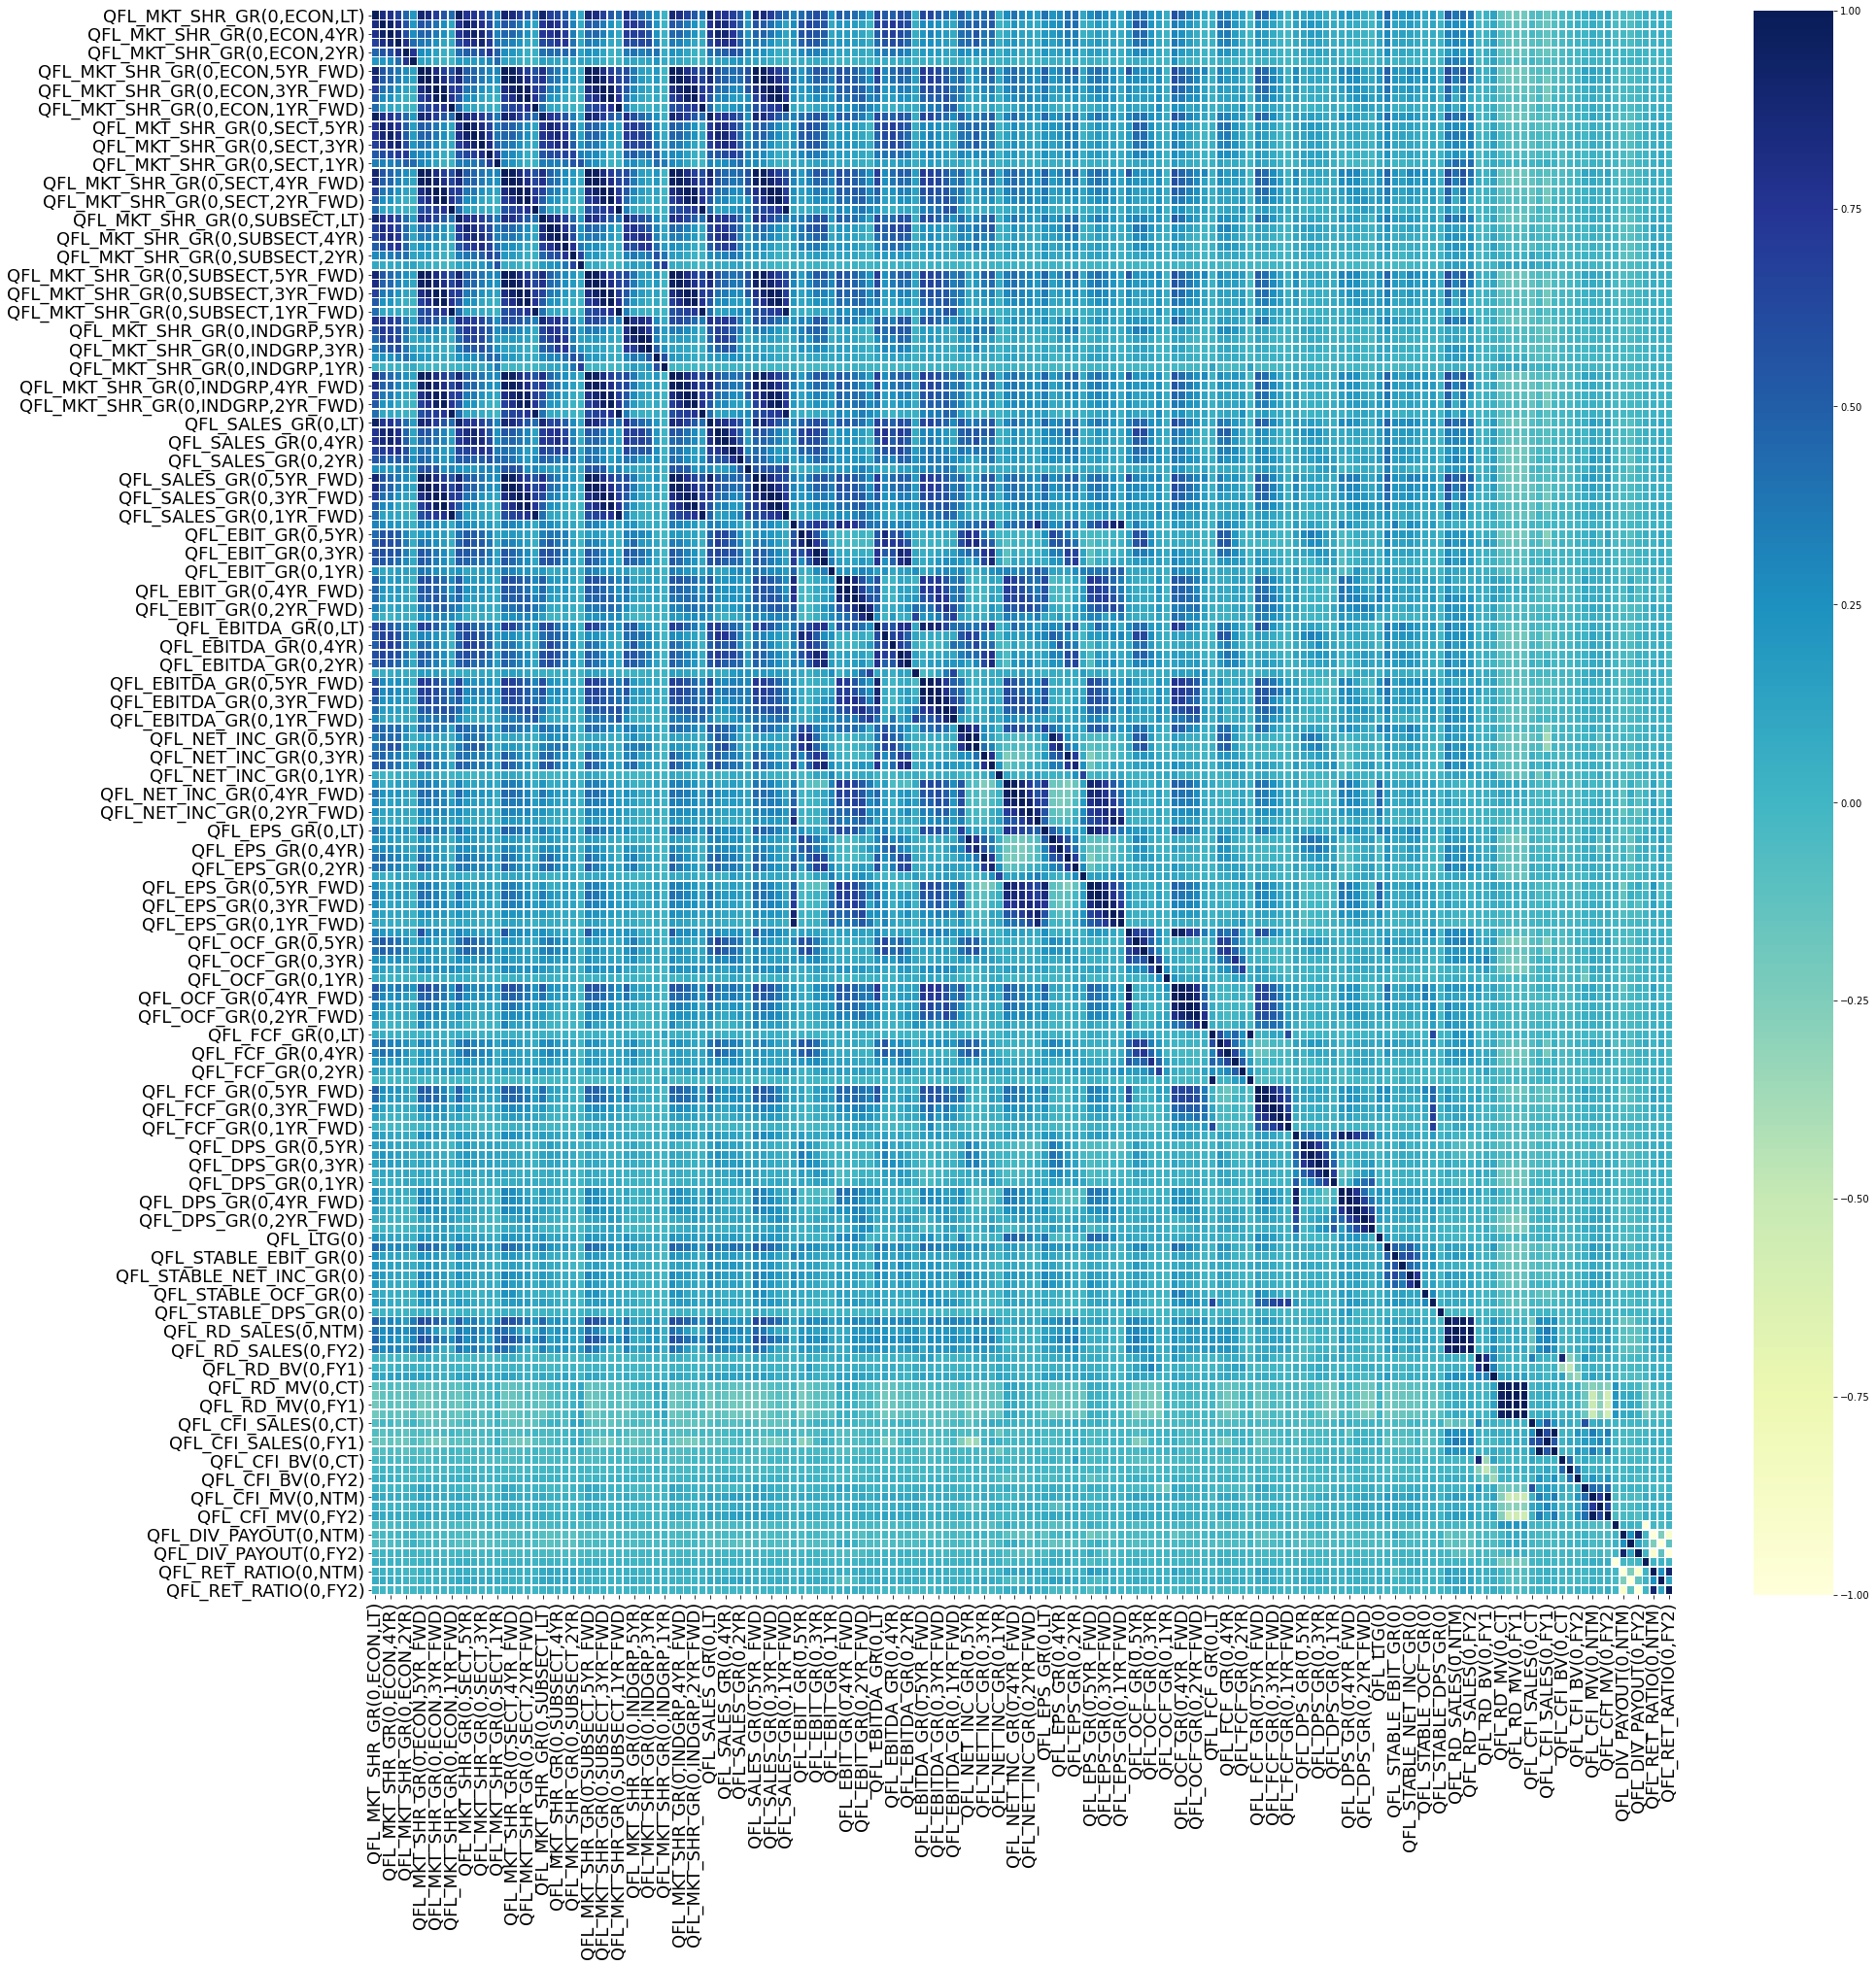

In [50]:
## Plot the correlation between each pair of factors

fig, ax = plt.subplots(figsize=(30,30))
hm = sns.heatmap(qfl_df[[c for c in qfl_df.columns[filter_idx]]].corr(), cmap="YlGnBu", annot = False, linewidths=.5, ax = ax)
hm.set_yticklabels(hm.get_ymajorticklabels(), fontsize = 18, rotation=0)
hm.set_xticklabels(hm.get_xmajorticklabels(), fontsize = 18, rotation=90)
plt.show()

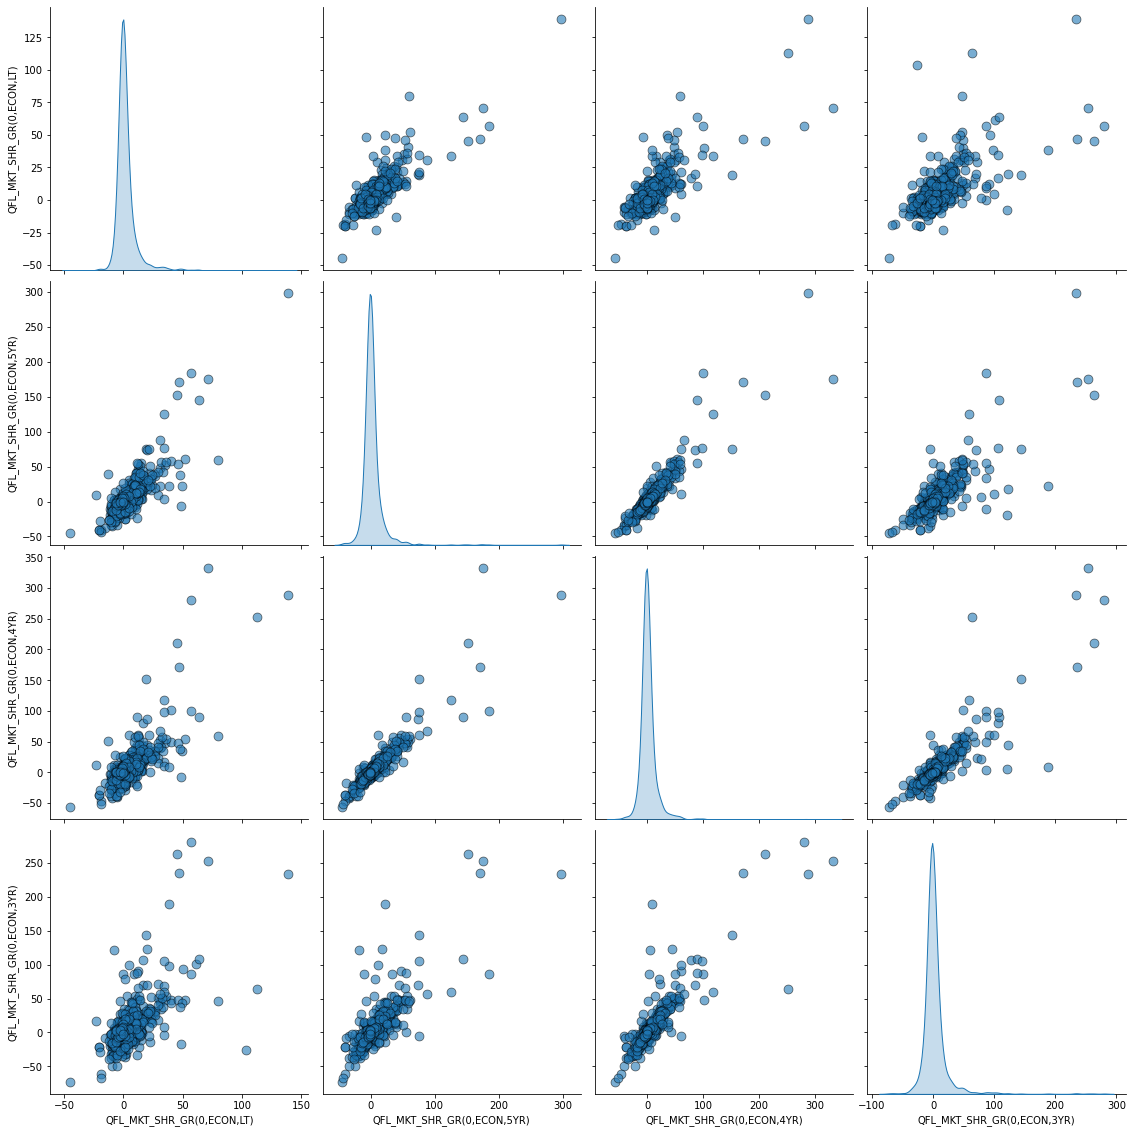

In [14]:
# Pairplot

sns.pairplot(qfl_df[qfl_df.columns[filter_idx[:4]].values], diag_kind = 'kde',
             plot_kws = {'alpha': 0.6, 's': 80, 'edgecolor': 'k'}, height = 4);
#plt.show()

In [15]:
qfl_df[qfl_df.columns[filter_idx[:4]].values]

,"QFL_MKT_SHR_GR(0,ECON,LT)","QFL_MKT_SHR_GR(0,ECON,5YR)","QFL_MKT_SHR_GR(0,ECON,4YR)","QFL_MKT_SHR_GR(0,ECON,3YR)"
0,-0.017275,-2.232145,-1.633197,-2.248029
1,3.177104,3.086383,5.897566,8.179630
2,16.348915,25.612082,24.474266,22.879215
3,16.672447,33.424194,30.447645,26.876043
4,10.268415,14.806673,14.884108,14.675749
...,...,...,...,...
1595,-1.953565,0.781220,0.835178,1.510259
1596,-1.017064,4.943913,6.062902,6.900845
1597,-5.839018,-1.393900,0.596234,2.530928
1598,-2.690584,-0.792380,0.685069,3.483532


In [16]:
# Other Statistics

advanced_describe = {}
stats_table = pd.DataFrame()
for factor in list(qfl_df.columns[filter_idx].values):
    advanced_describe[factor] = stats.describe(qfl_df[factor].dropna(), axis=0)    
    adv_stats = {keys: [np.round(series, 2) for series in values] for (keys, values) in zip(advanced_describe.keys(), advanced_describe.values())}
    stats_table = pd.DataFrame(adv_stats, index=['nobs', 'minmax', 'mean', 'variance', 'skewness', 'kurtosis']).T
stats_table

,nobs,minmax,mean,variance,skewness,kurtosis
"QFL_MKT_SHR_GR(0,ECON,LT)",1596,"[-44.9, 139.19]",2.04,101.53,5.12,45.92
"QFL_MKT_SHR_GR(0,ECON,5YR)",1539,"[-44.9, 298.16]",1.99,304.09,6.74,81.95
"QFL_MKT_SHR_GR(0,ECON,4YR)",1561,"[-57.35, 333.05]",2.41,466.89,7.81,93.06
"QFL_MKT_SHR_GR(0,ECON,3YR)",1578,"[-72.9, 280.33]",2.19,503.79,5.93,56.56
"QFL_MKT_SHR_GR(0,ECON,2YR)",1587,"[-88.57, 269.94]",1.93,495.56,4.11,32.96
...,...,...,...,...,...,...
"QFL_DIV_PAYOUT(0,FY2)",1536,"[0.0, 896.83]",1.3,583.96,34.46,1242.7
"QFL_RET_RATIO(0,CT)",1468,"[-610.0, 2.54]",-0.51,297.21,-31.56,1079.61
"QFL_RET_RATIO(0,NTM)",1520,"[-70.27, 1.0]",0.43,4.05,-29.61,1009.52
"QFL_RET_RATIO(0,FY1)",1436,"[-35.06, 1.0]",0.39,1.92,-15.17,326.2


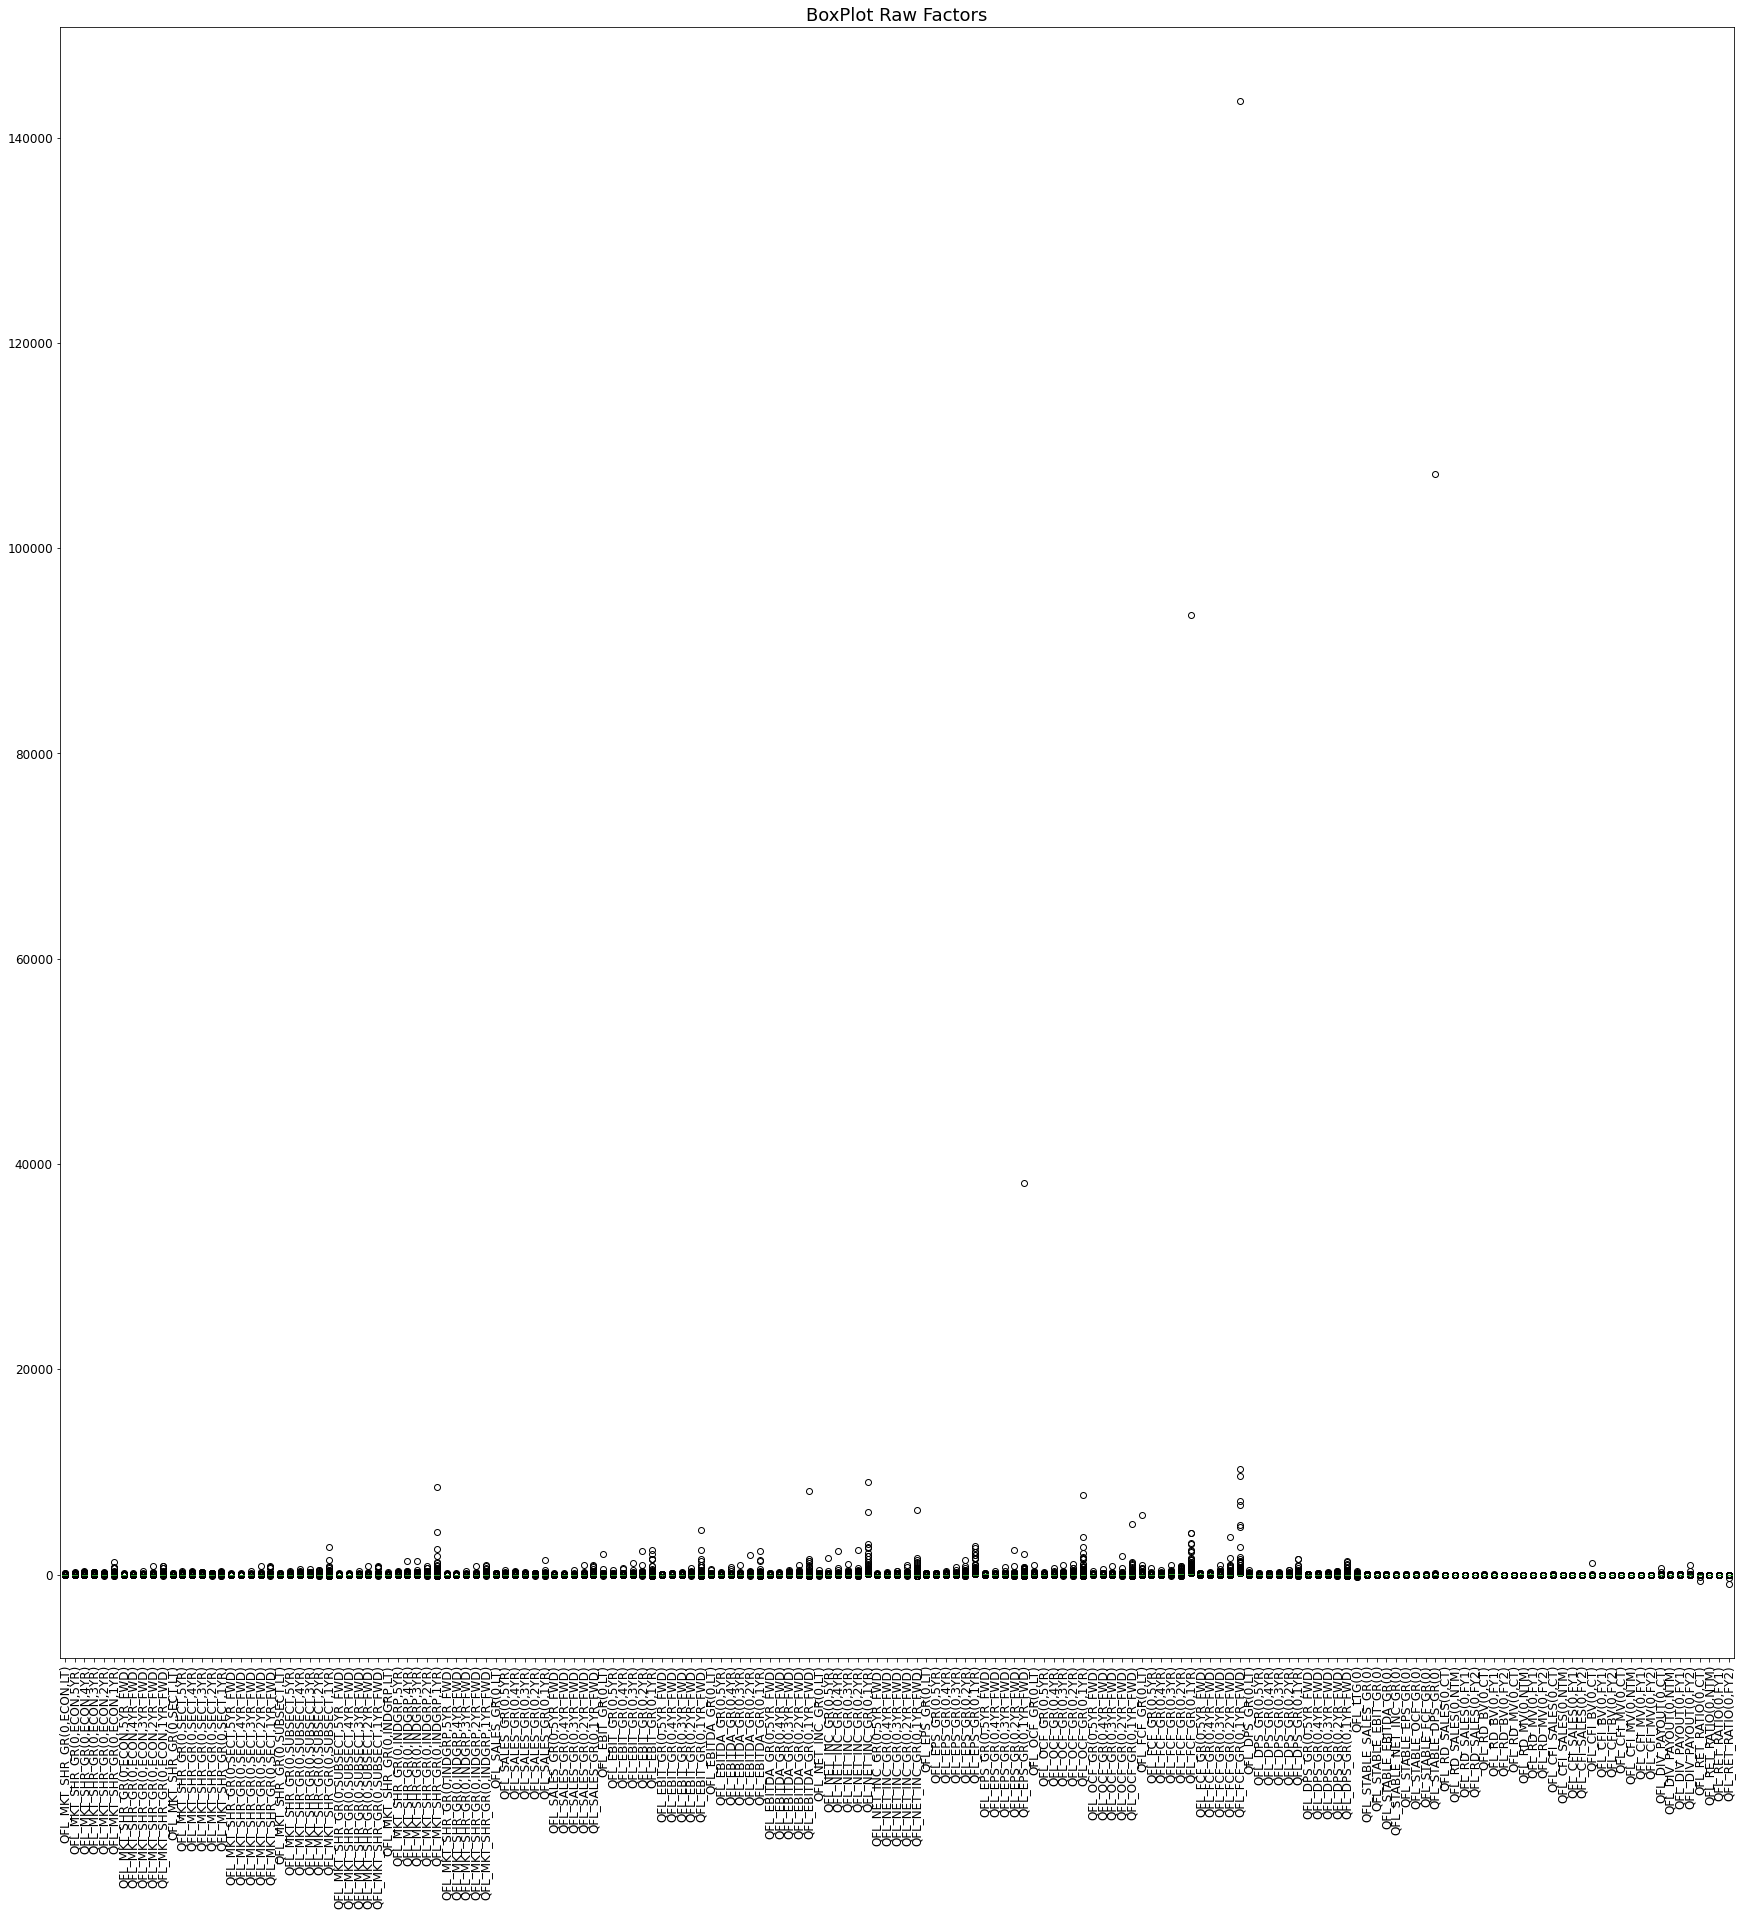

In [17]:
# Box-Whisker plot

qfl_df[qfl_df.columns[filter_idx]].boxplot(grid=False, rot=90, fontsize=12, figsize = (30,30)).set_title('BoxPlot Raw Factors', fontsize = 18);

In [18]:
# Z-Score

qfl_df_z = pd.DataFrame()

for factor in qfl_df[qfl_df.columns[filter_idx]]:
    z_score = ( qfl_df[factor] - qfl_df[factor].mean() ) / qfl_df[factor].std()
    qfl_df_z[factor] = z_score

qfl_df_z.describe()

,"QFL_MKT_SHR_GR(0,ECON,LT)","QFL_MKT_SHR_GR(0,ECON,5YR)","QFL_MKT_SHR_GR(0,ECON,4YR)","QFL_MKT_SHR_GR(0,ECON,3YR)","QFL_MKT_SHR_GR(0,ECON,2YR)","QFL_MKT_SHR_GR(0,ECON,1YR)","QFL_MKT_SHR_GR(0,ECON,5YR_FWD)","QFL_MKT_SHR_GR(0,ECON,4YR_FWD)","QFL_MKT_SHR_GR(0,ECON,3YR_FWD)","QFL_MKT_SHR_GR(0,ECON,2YR_FWD)","QFL_MKT_SHR_GR(0,ECON,1YR_FWD)","QFL_MKT_SHR_GR(0,SECT,LT)","QFL_MKT_SHR_GR(0,SECT,5YR)","QFL_MKT_SHR_GR(0,SECT,4YR)","QFL_MKT_SHR_GR(0,SECT,3YR)","QFL_MKT_SHR_GR(0,SECT,2YR)","QFL_MKT_SHR_GR(0,SECT,1YR)","QFL_MKT_SHR_GR(0,SECT,5YR_FWD)","QFL_MKT_SHR_GR(0,SECT,4YR_FWD)","QFL_MKT_SHR_GR(0,SECT,3YR_FWD)","QFL_MKT_SHR_GR(0,SECT,2YR_FWD)","QFL_MKT_SHR_GR(0,SECT,1YR_FWD)","QFL_MKT_SHR_GR(0,SUBSECT,LT)","QFL_MKT_SHR_GR(0,SUBSECT,5YR)","QFL_MKT_SHR_GR(0,SUBSECT,4YR)","QFL_MKT_SHR_GR(0,SUBSECT,3YR)","QFL_MKT_SHR_GR(0,SUBSECT,2YR)","QFL_MKT_SHR_GR(0,SUBSECT,1YR)","QFL_MKT_SHR_GR(0,SUBSECT,5YR_FWD)","QFL_MKT_SHR_GR(0,SUBSECT,4YR_FWD)","QFL_MKT_SHR_GR(0,SUBSECT,3YR_FWD)","QFL_MKT_SHR_GR(0,SUBSECT,2YR_FWD)","QFL_MKT_SHR_GR(0,SUBSECT,1YR_FWD)","QFL_MKT_SHR_GR(0,INDGRP,LT)","QFL_MKT_SHR_GR(0,INDGRP,5YR)","QFL_MKT_SHR_GR(0,INDGRP,4YR)","QFL_MKT_SHR_GR(0,INDGRP,3YR)","QFL_MKT_SHR_GR(0,INDGRP,2YR)","QFL_MKT_SHR_GR(0,INDGRP,1YR)","QFL_MKT_SHR_GR(0,INDGRP,5YR_FWD)","QFL_MKT_SHR_GR(0,INDGRP,4YR_FWD)","QFL_MKT_SHR_GR(0,INDGRP,3YR_FWD)","QFL_MKT_SHR_GR(0,INDGRP,2YR_FWD)","QFL_MKT_SHR_GR(0,INDGRP,1YR_FWD)","QFL_SALES_GR(0,LT)","QFL_SALES_GR(0,5YR)","QFL_SALES_GR(0,4YR)","QFL_SALES_GR(0,3YR)","QFL_SALES_GR(0,2YR)","QFL_SALES_GR(0,1YR)","QFL_SALES_GR(0,5YR_FWD)","QFL_SALES_GR(0,4YR_FWD)","QFL_SALES_GR(0,3YR_FWD)","QFL_SALES_GR(0,2YR_FWD)","QFL_SALES_GR(0,1YR_FWD)","QFL_EBIT_GR(0,LT)","QFL_EBIT_GR(0,5YR)","QFL_EBIT_GR(0,4YR)","QFL_EBIT_GR(0,3YR)","QFL_EBIT_GR(0,2YR)","QFL_EBIT_GR(0,1YR)","QFL_EBIT_GR(0,5YR_FWD)","QFL_EBIT_GR(0,4YR_FWD)","QFL_EBIT_GR(0,3YR_FWD)","QFL_EBIT_GR(0,2YR_FWD)","QFL_EBIT_GR(0,1YR_FWD)","QFL_EBITDA_GR(0,LT)","QFL_EBITDA_GR(0,5YR)","QFL_EBITDA_GR(0,4YR)","QFL_EBITDA_GR(0,3YR)","QFL_EBITDA_GR(0,2YR)","QFL_EBITDA_GR(0,1YR)","QFL_EBITDA_GR(0,5YR_FWD)","QFL_EBITDA_GR(0,4YR_FWD)","QFL_EBITDA_GR(0,3YR_FWD)","QFL_EBITDA_GR(0,2YR_FWD)","QFL_EBITDA_GR(0,1YR_FWD)","QFL_NET_INC_GR(0,LT)","QFL_NET_INC_GR(0,5YR)","QFL_NET_INC_GR(0,4YR)","QFL_NET_INC_GR(0,3YR)","QFL_NET_INC_GR(0,2YR)","QFL_NET_INC_GR(0,1YR)","QFL_NET_INC_GR(0,5YR_FWD)","QFL_NET_INC_GR(0,4YR_FWD)","QFL_NET_INC_GR(0,3YR_FWD)","QFL_NET_INC_GR(0,2YR_FWD)","QFL_NET_INC_GR(0,1YR_FWD)","QFL_EPS_GR(0,LT)","QFL_EPS_GR(0,5YR)","QFL_EPS_GR(0,4YR)","QFL_EPS_GR(0,3YR)","QFL_EPS_GR(0,2YR)","QFL_EPS_GR(0,1YR)","QFL_EPS_GR(0,5YR_FWD)","QFL_EPS_GR(0,4YR_FWD)","QFL_EPS_GR(0,3YR_FWD)","QFL_EPS_GR(0,2YR_FWD)","QFL_EPS_GR(0,1YR_FWD)","QFL_OCF_GR(0,LT)","QFL_OCF_GR(0,5YR)","QFL_OCF_GR(0,4YR)","QFL_OCF_GR(0,3YR)","QFL_OCF_GR(0,2YR)","QFL_OCF_GR(0,1YR)","QFL_OCF_GR(0,5YR_FWD)","QFL_OCF_GR(0,4YR_FWD)","QFL_OCF_GR(0,3YR_FWD)","QFL_OCF_GR(0,2YR_FWD)","QFL_OCF_GR(0,1YR_FWD)","QFL_FCF_GR(0,LT)","QFL_FCF_GR(0,5YR)","QFL_FCF_GR(0,4YR)","QFL_FCF_GR(0,3YR)","QFL_FCF_GR(0,2YR)","QFL_FCF_GR(0,1YR)","QFL_FCF_GR(0,5YR_FWD)","QFL_FCF_GR(0,4YR_FWD)","QFL_FCF_GR(0,3YR_FWD)","QFL_FCF_GR(0,2YR_FWD)","QFL_FCF_GR(0,1YR_FWD)","QFL_DPS_GR(0,LT)","QFL_DPS_GR(0,5YR)","QFL_DPS_GR(0,4YR)","QFL_DPS_GR(0,3YR)","QFL_DPS_GR(0,2YR)","QFL_DPS_GR(0,1YR)","QFL_DPS_GR(0,5YR_FWD)","QFL_DPS_GR(0,4YR_FWD)","QFL_DPS_GR(0,3YR_FWD)","QFL_DPS_GR(0,2YR_FWD)","QFL_DPS_GR(0,1YR_FWD)",QFL_LTG(0),QFL_STABLE_SALES_GR(0),QFL_STABLE_EBIT_GR(0),QFL_STABLE_EBITDA_GR(0),QFL_STABLE_NET_INC_GR(0),QFL_STABLE_EPS_GR(0),QFL_STABLE_OCF_GR(0),QFL_STABLE_FCF_GR(0),QFL_STABLE_DPS_GR(0),"QFL_RD_SALES(0,CT)","QFL_RD_SALES(0,NTM)","QFL_RD_SALES(0,FY1)","QFL_RD_SALES(0,FY2)","QFL_RD_BV(0,CT)","QFL_RD_BV(0,FY1)","QFL_RD_BV(0,FY2)","QFL_RD_MV(0,CT)","QFL_RD_MV(0,NTM)","QFL_RD_MV(0,FY1)","QFL_RD_MV(0,FY2)","QFL_CFI_SALES(0,CT)","QFL_CFI_SALES(0,NTM)","QFL_CFI_SALES(0,FY1)","QFL_CFI_SALES(0,FY2)","QFL_CFI_BV(0,CT)","QFL_CFI_BV(0,FY1)","QFL_CFI_BV(0,FY2)","QFL_CFI_MV(0

In [19]:
# look for "extremely large" column's values after normalization (Descending)

for col_z in qfl_df_z:
    qfl_df_z[col_z] = qfl_df_z[col_z].sort_values(ignore_index=True, ascending = False)
    
qfl_df_z

,"QFL_MKT_SHR_GR(0,ECON,LT)","QFL_MKT_SHR_GR(0,ECON,5YR)","QFL_MKT_SHR_GR(0,ECON,4YR)","QFL_MKT_SHR_GR(0,ECON,3YR)","QFL_MKT_SHR_GR(0,ECON,2YR)","QFL_MKT_SHR_GR(0,ECON,1YR)","QFL_MKT_SHR_GR(0,ECON,5YR_FWD)","QFL_MKT_SHR_GR(0,ECON,4YR_FWD)","QFL_MKT_SHR_GR(0,ECON,3YR_FWD)","QFL_MKT_SHR_GR(0,ECON,2YR_FWD)","QFL_MKT_SHR_GR(0,ECON,1YR_FWD)","QFL_MKT_SHR_GR(0,SECT,LT)","QFL_MKT_SHR_GR(0,SECT,5YR)","QFL_MKT_SHR_GR(0,SECT,4YR)","QFL_MKT_SHR_GR(0,SECT,3YR)","QFL_MKT_SHR_GR(0,SECT,2YR)","QFL_MKT_SHR_GR(0,SECT,1YR)","QFL_MKT_SHR_GR(0,SECT,5YR_FWD)","QFL_MKT_SHR_GR(0,SECT,4YR_FWD)","QFL_MKT_SHR_GR(0,SECT,3YR_FWD)","QFL_MKT_SHR_GR(0,SECT,2YR_FWD)","QFL_MKT_SHR_GR(0,SECT,1YR_FWD)","QFL_MKT_SHR_GR(0,SUBSECT,LT)","QFL_MKT_SHR_GR(0,SUBSECT,5YR)","QFL_MKT_SHR_GR(0,SUBSECT,4YR)","QFL_MKT_SHR_GR(0,SUBSECT,3YR)","QFL_MKT_SHR_GR(0,SUBSECT,2YR)","QFL_MKT_SHR_GR(0,SUBSECT,1YR)","QFL_MKT_SHR_GR(0,SUBSECT,5YR_FWD)","QFL_MKT_SHR_GR(0,SUBSECT,4YR_FWD)","QFL_MKT_SHR_GR(0,SUBSECT,3YR_FWD)","QFL_MKT_SHR_GR(0,SUBSECT,2YR_FWD)","QFL_MKT_SHR_GR(0,SUBSECT,1YR_FWD)","QFL_MKT_SHR_GR(0,INDGRP,LT)","QFL_MKT_SHR_GR(0,INDGRP,5YR)","QFL_MKT_SHR_GR(0,INDGRP,4YR)","QFL_MKT_SHR_GR(0,INDGRP,3YR)","QFL_MKT_SHR_GR(0,INDGRP,2YR)","QFL_MKT_SHR_GR(0,INDGRP,1YR)","QFL_MKT_SHR_GR(0,INDGRP,5YR_FWD)","QFL_MKT_SHR_GR(0,INDGRP,4YR_FWD)","QFL_MKT_SHR_GR(0,INDGRP,3YR_FWD)","QFL_MKT_SHR_GR(0,INDGRP,2YR_FWD)","QFL_MKT_SHR_GR(0,INDGRP,1YR_FWD)","QFL_SALES_GR(0,LT)","QFL_SALES_GR(0,5YR)","QFL_SALES_GR(0,4YR)","QFL_SALES_GR(0,3YR)","QFL_SALES_GR(0,2YR)","QFL_SALES_GR(0,1YR)","QFL_SALES_GR(0,5YR_FWD)","QFL_SALES_GR(0,4YR_FWD)","QFL_SALES_GR(0,3YR_FWD)","QFL_SALES_GR(0,2YR_FWD)","QFL_SALES_GR(0,1YR_FWD)","QFL_EBIT_GR(0,LT)","QFL_EBIT_GR(0,5YR)","QFL_EBIT_GR(0,4YR)","QFL_EBIT_GR(0,3YR)","QFL_EBIT_GR(0,2YR)","QFL_EBIT_GR(0,1YR)","QFL_EBIT_GR(0,5YR_FWD)","QFL_EBIT_GR(0,4YR_FWD)","QFL_EBIT_GR(0,3YR_FWD)","QFL_EBIT_GR(0,2YR_FWD)","QFL_EBIT_GR(0,1YR_FWD)","QFL_EBITDA_GR(0,LT)","QFL_EBITDA_GR(0,5YR)","QFL_EBITDA_GR(0,4YR)","QFL_EBITDA_GR(0,3YR)","QFL_EBITDA_GR(0,2YR)","QFL_EBITDA_GR(0,1YR)","QFL_EBITDA_GR(0,5YR_FWD)","QFL_EBITDA_GR(0,4YR_FWD)","QFL_EBITDA_GR(0,3YR_FWD)","QFL_EBITDA_GR(0,2YR_FWD)","QFL_EBITDA_GR(0,1YR_FWD)","QFL_NET_INC_GR(0,LT)","QFL_NET_INC_GR(0,5YR)","QFL_NET_INC_GR(0,4YR)","QFL_NET_INC_GR(0,3YR)","QFL_NET_INC_GR(0,2YR)","QFL_NET_INC_GR(0,1YR)","QFL_NET_INC_GR(0,5YR_FWD)","QFL_NET_INC_GR(0,4YR_FWD)","QFL_NET_INC_GR(0,3YR_FWD)","QFL_NET_INC_GR(0,2YR_FWD)","QFL_NET_INC_GR(0,1YR_FWD)","QFL_EPS_GR(0,LT)","QFL_EPS_GR(0,5YR)","QFL_EPS_GR(0,4YR)","QFL_EPS_GR(0,3YR)","QFL_EPS_GR(0,2YR)","QFL_EPS_GR(0,1YR)","QFL_EPS_GR(0,5YR_FWD)","QFL_EPS_GR(0,4YR_FWD)","QFL_EPS_GR(0,3YR_FWD)","QFL_EPS_GR(0,2YR_FWD)","QFL_EPS_GR(0,1YR_FWD)","QFL_OCF_GR(0,LT)","QFL_OCF_GR(0,5YR)","QFL_OCF_GR(0,4YR)","QFL_OCF_GR(0,3YR)","QFL_OCF_GR(0,2YR)","QFL_OCF_GR(0,1YR)","QFL_OCF_GR(0,5YR_FWD)","QFL_OCF_GR(0,4YR_FWD)","QFL_OCF_GR(0,3YR_FWD)","QFL_OCF_GR(0,2YR_FWD)","QFL_OCF_GR(0,1YR_FWD)","QFL_FCF_GR(0,LT)","QFL_FCF_GR(0,5YR)","QFL_FCF_GR(0,4YR)","QFL_FCF_GR(0,3YR)","QFL_FCF_GR(0,2YR)","QFL_FCF_GR(0,1YR)","QFL_FCF_GR(0,5YR_FWD)","QFL_FCF_GR(0,4YR_FWD)","QFL_FCF_GR(0,3YR_FWD)","QFL_FCF_GR(0,2YR_FWD)","QFL_FCF_GR(0,1YR_FWD)","QFL_DPS_GR(0,LT)","QFL_DPS_GR(0,5YR)","QFL_DPS_GR(0,4YR)","QFL_DPS_GR(0,3YR)","QFL_DPS_GR(0,2YR)","QFL_DPS_GR(0,1YR)","QFL_DPS_GR(0,5YR_FWD)","QFL_DPS_GR(0,4YR_FWD)","QFL_DPS_GR(0,3YR_FWD)","QFL_DPS_GR(0,2YR_FWD)","QFL_DPS_GR(0,1YR_FWD)",QFL_LTG(0),QFL_STABLE_SALES_GR(0),QFL_STABLE_EBIT_GR(0),QFL_STABLE_EBITDA_GR(0),QFL_STABLE_NET_INC_GR(0),QFL_STABLE_EPS_GR(0),QFL_STABLE_OCF_GR(0),QFL_STABLE_FCF_GR(0),QFL_STABLE_DPS_GR(0),"QFL_RD_SALES(0,CT)","QFL_RD_SALES(0,NTM)","QFL_RD_SALES(0,FY1)","QFL_RD_SALES(0,FY2)","QFL_RD_BV(0,CT)","QFL_RD_BV(0,FY1)","QFL_RD_BV(0,FY2)","QFL_RD_MV(0,CT)","QFL_RD_MV(0,NTM)","QFL_RD_MV(0,FY1)","QFL_RD_MV(0,FY2)","QFL_CFI_SALES(0,CT)","QFL_CFI_SALES(0,NTM)","QFL_CFI_SALES(0,FY1)","QFL_CFI_SALES(0,FY2)","QFL_CFI_BV(0,CT)","QFL_CFI_BV(0,FY1)","QFL_CFI_BV(0,FY2)","QFL_CFI_MV(0

In [20]:
# look for "extremely large" column's values after normalization (Ascending)

for col_z in qfl_df_z:
    qfl_df_z[col_z] = qfl_df_z[col_z].sort_values(ignore_index=True, ascending = True)
    
qfl_df_z

,"QFL_MKT_SHR_GR(0,ECON,LT)","QFL_MKT_SHR_GR(0,ECON,5YR)","QFL_MKT_SHR_GR(0,ECON,4YR)","QFL_MKT_SHR_GR(0,ECON,3YR)","QFL_MKT_SHR_GR(0,ECON,2YR)","QFL_MKT_SHR_GR(0,ECON,1YR)","QFL_MKT_SHR_GR(0,ECON,5YR_FWD)","QFL_MKT_SHR_GR(0,ECON,4YR_FWD)","QFL_MKT_SHR_GR(0,ECON,3YR_FWD)","QFL_MKT_SHR_GR(0,ECON,2YR_FWD)","QFL_MKT_SHR_GR(0,ECON,1YR_FWD)","QFL_MKT_SHR_GR(0,SECT,LT)","QFL_MKT_SHR_GR(0,SECT,5YR)","QFL_MKT_SHR_GR(0,SECT,4YR)","QFL_MKT_SHR_GR(0,SECT,3YR)","QFL_MKT_SHR_GR(0,SECT,2YR)","QFL_MKT_SHR_GR(0,SECT,1YR)","QFL_MKT_SHR_GR(0,SECT,5YR_FWD)","QFL_MKT_SHR_GR(0,SECT,4YR_FWD)","QFL_MKT_SHR_GR(0,SECT,3YR_FWD)","QFL_MKT_SHR_GR(0,SECT,2YR_FWD)","QFL_MKT_SHR_GR(0,SECT,1YR_FWD)","QFL_MKT_SHR_GR(0,SUBSECT,LT)","QFL_MKT_SHR_GR(0,SUBSECT,5YR)","QFL_MKT_SHR_GR(0,SUBSECT,4YR)","QFL_MKT_SHR_GR(0,SUBSECT,3YR)","QFL_MKT_SHR_GR(0,SUBSECT,2YR)","QFL_MKT_SHR_GR(0,SUBSECT,1YR)","QFL_MKT_SHR_GR(0,SUBSECT,5YR_FWD)","QFL_MKT_SHR_GR(0,SUBSECT,4YR_FWD)","QFL_MKT_SHR_GR(0,SUBSECT,3YR_FWD)","QFL_MKT_SHR_GR(0,SUBSECT,2YR_FWD)","QFL_MKT_SHR_GR(0,SUBSECT,1YR_FWD)","QFL_MKT_SHR_GR(0,INDGRP,LT)","QFL_MKT_SHR_GR(0,INDGRP,5YR)","QFL_MKT_SHR_GR(0,INDGRP,4YR)","QFL_MKT_SHR_GR(0,INDGRP,3YR)","QFL_MKT_SHR_GR(0,INDGRP,2YR)","QFL_MKT_SHR_GR(0,INDGRP,1YR)","QFL_MKT_SHR_GR(0,INDGRP,5YR_FWD)","QFL_MKT_SHR_GR(0,INDGRP,4YR_FWD)","QFL_MKT_SHR_GR(0,INDGRP,3YR_FWD)","QFL_MKT_SHR_GR(0,INDGRP,2YR_FWD)","QFL_MKT_SHR_GR(0,INDGRP,1YR_FWD)","QFL_SALES_GR(0,LT)","QFL_SALES_GR(0,5YR)","QFL_SALES_GR(0,4YR)","QFL_SALES_GR(0,3YR)","QFL_SALES_GR(0,2YR)","QFL_SALES_GR(0,1YR)","QFL_SALES_GR(0,5YR_FWD)","QFL_SALES_GR(0,4YR_FWD)","QFL_SALES_GR(0,3YR_FWD)","QFL_SALES_GR(0,2YR_FWD)","QFL_SALES_GR(0,1YR_FWD)","QFL_EBIT_GR(0,LT)","QFL_EBIT_GR(0,5YR)","QFL_EBIT_GR(0,4YR)","QFL_EBIT_GR(0,3YR)","QFL_EBIT_GR(0,2YR)","QFL_EBIT_GR(0,1YR)","QFL_EBIT_GR(0,5YR_FWD)","QFL_EBIT_GR(0,4YR_FWD)","QFL_EBIT_GR(0,3YR_FWD)","QFL_EBIT_GR(0,2YR_FWD)","QFL_EBIT_GR(0,1YR_FWD)","QFL_EBITDA_GR(0,LT)","QFL_EBITDA_GR(0,5YR)","QFL_EBITDA_GR(0,4YR)","QFL_EBITDA_GR(0,3YR)","QFL_EBITDA_GR(0,2YR)","QFL_EBITDA_GR(0,1YR)","QFL_EBITDA_GR(0,5YR_FWD)","QFL_EBITDA_GR(0,4YR_FWD)","QFL_EBITDA_GR(0,3YR_FWD)","QFL_EBITDA_GR(0,2YR_FWD)","QFL_EBITDA_GR(0,1YR_FWD)","QFL_NET_INC_GR(0,LT)","QFL_NET_INC_GR(0,5YR)","QFL_NET_INC_GR(0,4YR)","QFL_NET_INC_GR(0,3YR)","QFL_NET_INC_GR(0,2YR)","QFL_NET_INC_GR(0,1YR)","QFL_NET_INC_GR(0,5YR_FWD)","QFL_NET_INC_GR(0,4YR_FWD)","QFL_NET_INC_GR(0,3YR_FWD)","QFL_NET_INC_GR(0,2YR_FWD)","QFL_NET_INC_GR(0,1YR_FWD)","QFL_EPS_GR(0,LT)","QFL_EPS_GR(0,5YR)","QFL_EPS_GR(0,4YR)","QFL_EPS_GR(0,3YR)","QFL_EPS_GR(0,2YR)","QFL_EPS_GR(0,1YR)","QFL_EPS_GR(0,5YR_FWD)","QFL_EPS_GR(0,4YR_FWD)","QFL_EPS_GR(0,3YR_FWD)","QFL_EPS_GR(0,2YR_FWD)","QFL_EPS_GR(0,1YR_FWD)","QFL_OCF_GR(0,LT)","QFL_OCF_GR(0,5YR)","QFL_OCF_GR(0,4YR)","QFL_OCF_GR(0,3YR)","QFL_OCF_GR(0,2YR)","QFL_OCF_GR(0,1YR)","QFL_OCF_GR(0,5YR_FWD)","QFL_OCF_GR(0,4YR_FWD)","QFL_OCF_GR(0,3YR_FWD)","QFL_OCF_GR(0,2YR_FWD)","QFL_OCF_GR(0,1YR_FWD)","QFL_FCF_GR(0,LT)","QFL_FCF_GR(0,5YR)","QFL_FCF_GR(0,4YR)","QFL_FCF_GR(0,3YR)","QFL_FCF_GR(0,2YR)","QFL_FCF_GR(0,1YR)","QFL_FCF_GR(0,5YR_FWD)","QFL_FCF_GR(0,4YR_FWD)","QFL_FCF_GR(0,3YR_FWD)","QFL_FCF_GR(0,2YR_FWD)","QFL_FCF_GR(0,1YR_FWD)","QFL_DPS_GR(0,LT)","QFL_DPS_GR(0,5YR)","QFL_DPS_GR(0,4YR)","QFL_DPS_GR(0,3YR)","QFL_DPS_GR(0,2YR)","QFL_DPS_GR(0,1YR)","QFL_DPS_GR(0,5YR_FWD)","QFL_DPS_GR(0,4YR_FWD)","QFL_DPS_GR(0,3YR_FWD)","QFL_DPS_GR(0,2YR_FWD)","QFL_DPS_GR(0,1YR_FWD)",QFL_LTG(0),QFL_STABLE_SALES_GR(0),QFL_STABLE_EBIT_GR(0),QFL_STABLE_EBITDA_GR(0),QFL_STABLE_NET_INC_GR(0),QFL_STABLE_EPS_GR(0),QFL_STABLE_OCF_GR(0),QFL_STABLE_FCF_GR(0),QFL_STABLE_DPS_GR(0),"QFL_RD_SALES(0,CT)","QFL_RD_SALES(0,NTM)","QFL_RD_SALES(0,FY1)","QFL_RD_SALES(0,FY2)","QFL_RD_BV(0,CT)","QFL_RD_BV(0,FY1)","QFL_RD_BV(0,FY2)","QFL_RD_MV(0,CT)","QFL_RD_MV(0,NTM)","QFL_RD_MV(0,FY1)","QFL_RD_MV(0,FY2)","QFL_CFI_SALES(0,CT)","QFL_CFI_SALES(0,NTM)","QFL_CFI_SALES(0,FY1)","QFL_CFI_SALES(0,FY2)","QFL_CFI_BV(0,CT)","QFL_CFI_BV(0,FY1)","QFL_CFI_BV(0,FY2)","QFL_CFI_MV(0

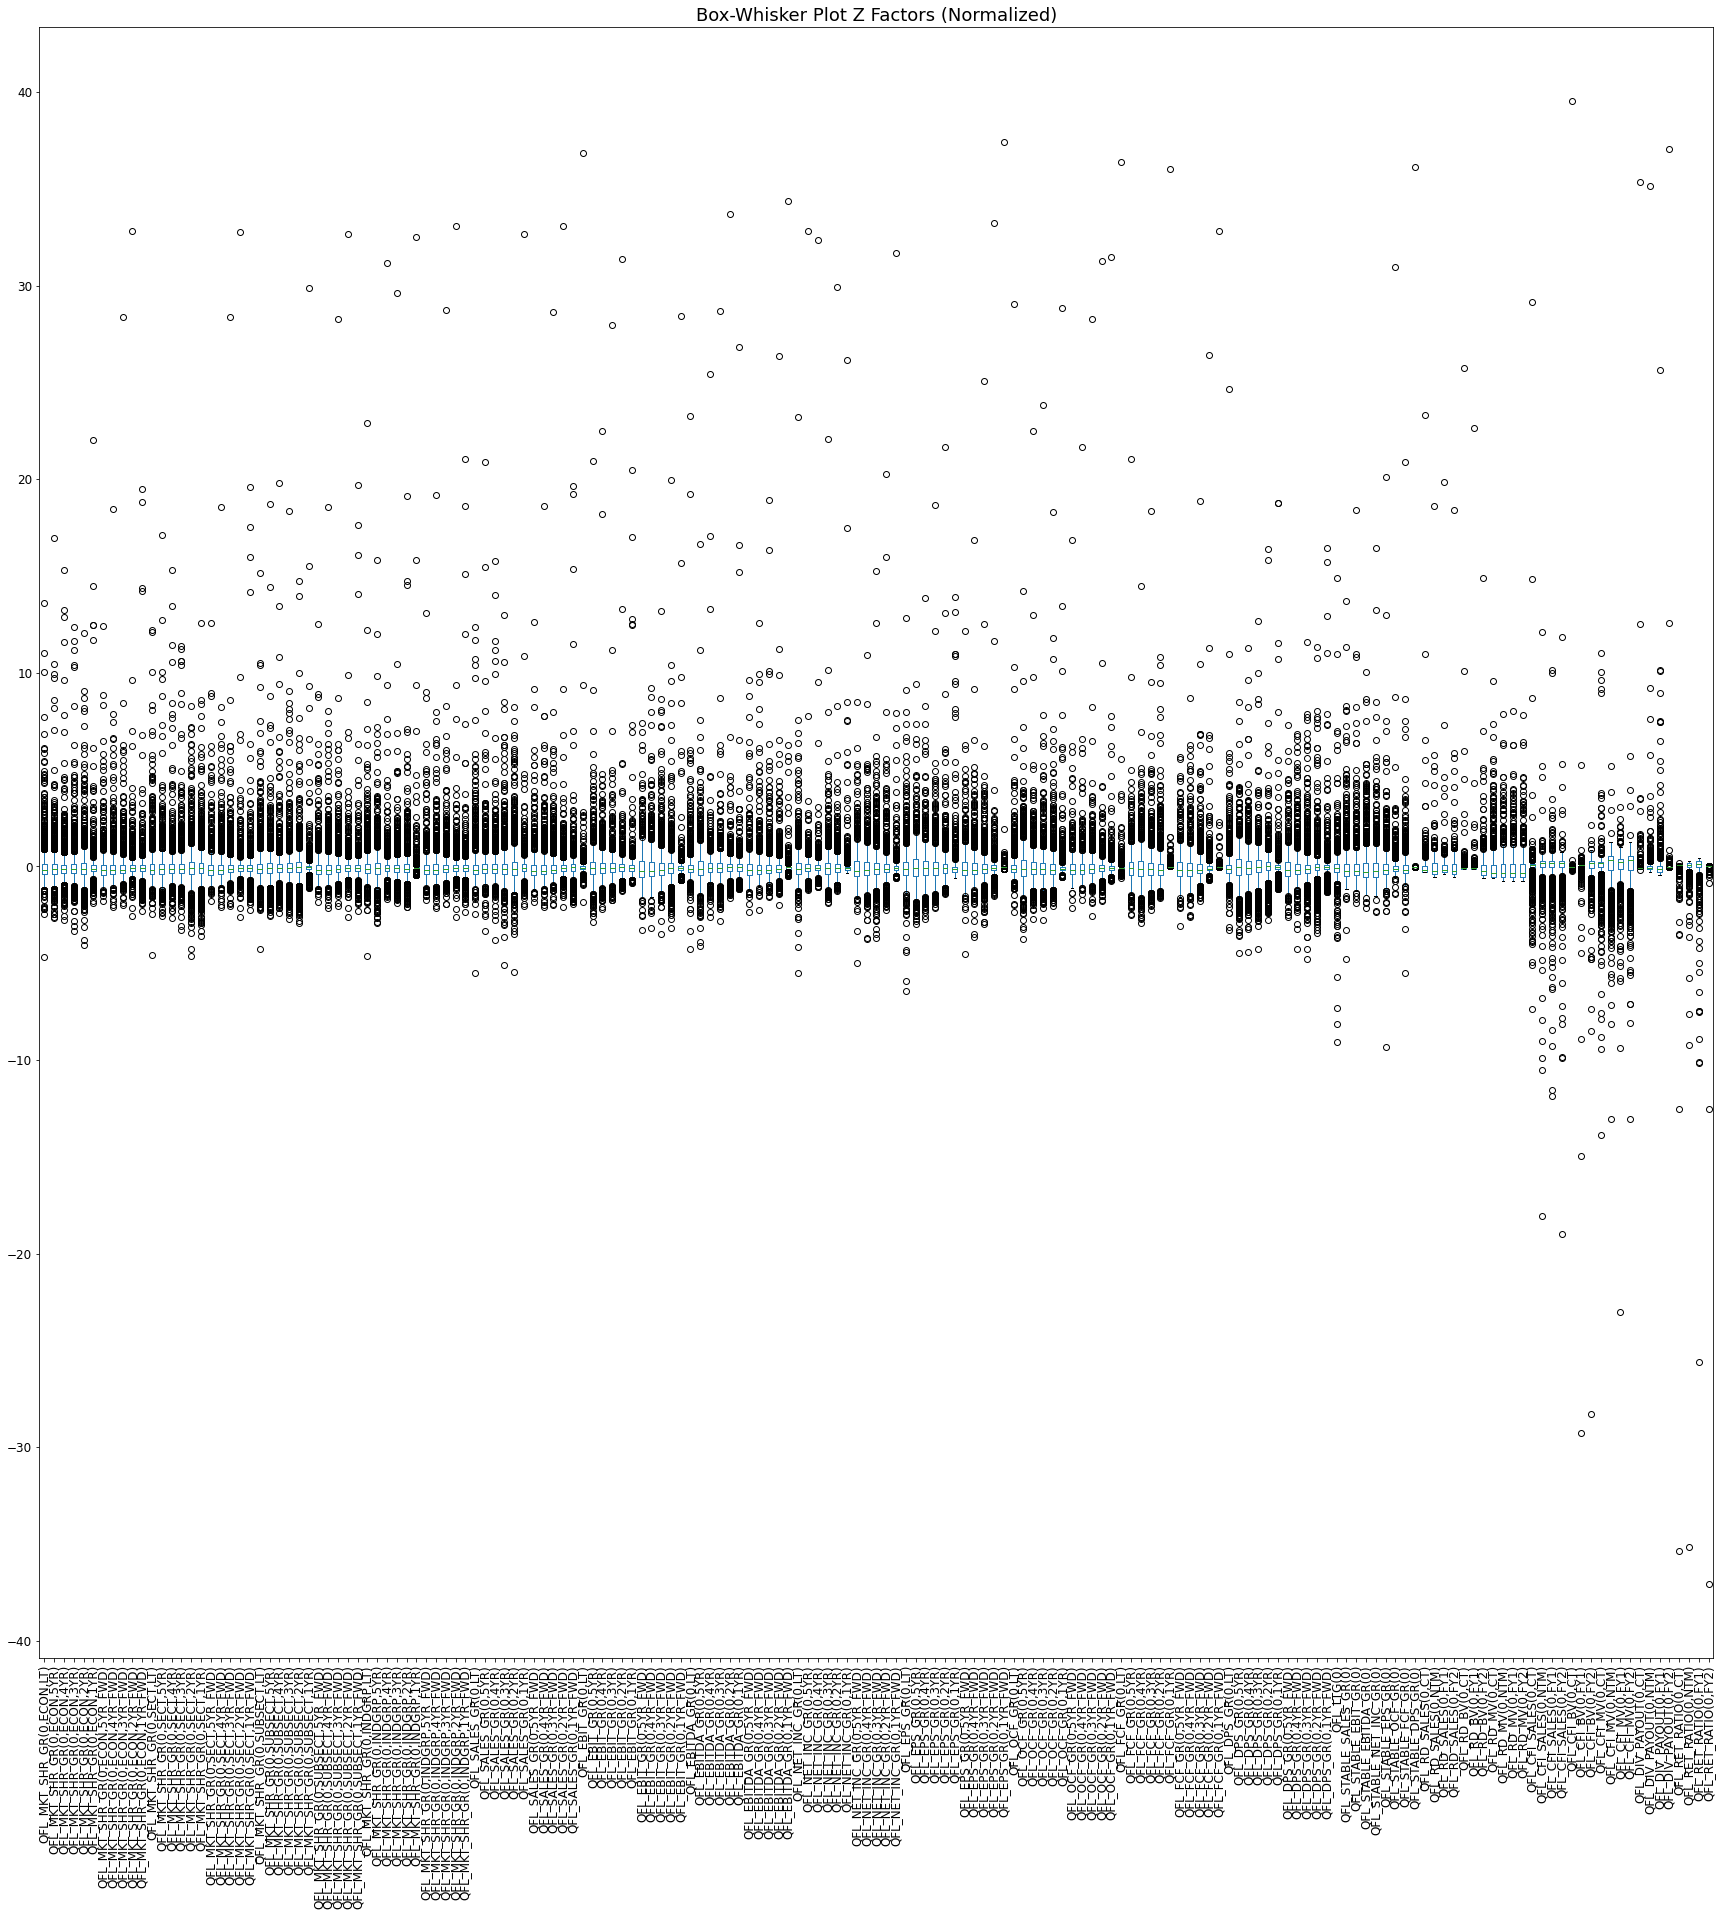

In [21]:
# Box-Whisker plot (Normalized data)

qfl_df_z.boxplot(grid=False, rot=90, fontsize=12, figsize = (30,30)).set_title('Box-Whisker Plot Z Factors (Normalized)', fontsize = 18);

In [22]:
# Greedy Multi-Factor Simple Average from all Multi-Factor's components

# MFR Z-Score

qfl_df_z['MFR'] = qfl_df_z.mean(axis = 1)

qfl_df_z.head()

,"QFL_MKT_SHR_GR(0,ECON,LT)","QFL_MKT_SHR_GR(0,ECON,5YR)","QFL_MKT_SHR_GR(0,ECON,4YR)","QFL_MKT_SHR_GR(0,ECON,3YR)","QFL_MKT_SHR_GR(0,ECON,2YR)","QFL_MKT_SHR_GR(0,ECON,1YR)","QFL_MKT_SHR_GR(0,ECON,5YR_FWD)","QFL_MKT_SHR_GR(0,ECON,4YR_FWD)","QFL_MKT_SHR_GR(0,ECON,3YR_FWD)","QFL_MKT_SHR_GR(0,ECON,2YR_FWD)","QFL_MKT_SHR_GR(0,ECON,1YR_FWD)","QFL_MKT_SHR_GR(0,SECT,LT)","QFL_MKT_SHR_GR(0,SECT,5YR)","QFL_MKT_SHR_GR(0,SECT,4YR)","QFL_MKT_SHR_GR(0,SECT,3YR)","QFL_MKT_SHR_GR(0,SECT,2YR)","QFL_MKT_SHR_GR(0,SECT,1YR)","QFL_MKT_SHR_GR(0,SECT,5YR_FWD)","QFL_MKT_SHR_GR(0,SECT,4YR_FWD)","QFL_MKT_SHR_GR(0,SECT,3YR_FWD)","QFL_MKT_SHR_GR(0,SECT,2YR_FWD)","QFL_MKT_SHR_GR(0,SECT,1YR_FWD)","QFL_MKT_SHR_GR(0,SUBSECT,LT)","QFL_MKT_SHR_GR(0,SUBSECT,5YR)","QFL_MKT_SHR_GR(0,SUBSECT,4YR)","QFL_MKT_SHR_GR(0,SUBSECT,3YR)","QFL_MKT_SHR_GR(0,SUBSECT,2YR)","QFL_MKT_SHR_GR(0,SUBSECT,1YR)","QFL_MKT_SHR_GR(0,SUBSECT,5YR_FWD)","QFL_MKT_SHR_GR(0,SUBSECT,4YR_FWD)","QFL_MKT_SHR_GR(0,SUBSECT,3YR_FWD)","QFL_MKT_SHR_GR(0,SUBSECT,2YR_FWD)","QFL_MKT_SHR_GR(0,SUBSECT,1YR_FWD)","QFL_MKT_SHR_GR(0,INDGRP,LT)","QFL_MKT_SHR_GR(0,INDGRP,5YR)","QFL_MKT_SHR_GR(0,INDGRP,4YR)","QFL_MKT_SHR_GR(0,INDGRP,3YR)","QFL_MKT_SHR_GR(0,INDGRP,2YR)","QFL_MKT_SHR_GR(0,INDGRP,1YR)","QFL_MKT_SHR_GR(0,INDGRP,5YR_FWD)","QFL_MKT_SHR_GR(0,INDGRP,4YR_FWD)","QFL_MKT_SHR_GR(0,INDGRP,3YR_FWD)","QFL_MKT_SHR_GR(0,INDGRP,2YR_FWD)","QFL_MKT_SHR_GR(0,INDGRP,1YR_FWD)","QFL_SALES_GR(0,LT)","QFL_SALES_GR(0,5YR)","QFL_SALES_GR(0,4YR)","QFL_SALES_GR(0,3YR)","QFL_SALES_GR(0,2YR)","QFL_SALES_GR(0,1YR)","QFL_SALES_GR(0,5YR_FWD)","QFL_SALES_GR(0,4YR_FWD)","QFL_SALES_GR(0,3YR_FWD)","QFL_SALES_GR(0,2YR_FWD)","QFL_SALES_GR(0,1YR_FWD)","QFL_EBIT_GR(0,LT)","QFL_EBIT_GR(0,5YR)","QFL_EBIT_GR(0,4YR)","QFL_EBIT_GR(0,3YR)","QFL_EBIT_GR(0,2YR)","QFL_EBIT_GR(0,1YR)","QFL_EBIT_GR(0,5YR_FWD)","QFL_EBIT_GR(0,4YR_FWD)","QFL_EBIT_GR(0,3YR_FWD)","QFL_EBIT_GR(0,2YR_FWD)","QFL_EBIT_GR(0,1YR_FWD)","QFL_EBITDA_GR(0,LT)","QFL_EBITDA_GR(0,5YR)","QFL_EBITDA_GR(0,4YR)","QFL_EBITDA_GR(0,3YR)","QFL_EBITDA_GR(0,2YR)","QFL_EBITDA_GR(0,1YR)","QFL_EBITDA_GR(0,5YR_FWD)","QFL_EBITDA_GR(0,4YR_FWD)","QFL_EBITDA_GR(0,3YR_FWD)","QFL_EBITDA_GR(0,2YR_FWD)","QFL_EBITDA_GR(0,1YR_FWD)","QFL_NET_INC_GR(0,LT)","QFL_NET_INC_GR(0,5YR)","QFL_NET_INC_GR(0,4YR)","QFL_NET_INC_GR(0,3YR)","QFL_NET_INC_GR(0,2YR)","QFL_NET_INC_GR(0,1YR)","QFL_NET_INC_GR(0,5YR_FWD)","QFL_NET_INC_GR(0,4YR_FWD)","QFL_NET_INC_GR(0,3YR_FWD)","QFL_NET_INC_GR(0,2YR_FWD)","QFL_NET_INC_GR(0,1YR_FWD)","QFL_EPS_GR(0,LT)","QFL_EPS_GR(0,5YR)","QFL_EPS_GR(0,4YR)","QFL_EPS_GR(0,3YR)","QFL_EPS_GR(0,2YR)","QFL_EPS_GR(0,1YR)","QFL_EPS_GR(0,5YR_FWD)","QFL_EPS_GR(0,4YR_FWD)","QFL_EPS_GR(0,3YR_FWD)","QFL_EPS_GR(0,2YR_FWD)","QFL_EPS_GR(0,1YR_FWD)","QFL_OCF_GR(0,LT)","QFL_OCF_GR(0,5YR)","QFL_OCF_GR(0,4YR)","QFL_OCF_GR(0,3YR)","QFL_OCF_GR(0,2YR)","QFL_OCF_GR(0,1YR)","QFL_OCF_GR(0,5YR_FWD)","QFL_OCF_GR(0,4YR_FWD)","QFL_OCF_GR(0,3YR_FWD)","QFL_OCF_GR(0,2YR_FWD)","QFL_OCF_GR(0,1YR_FWD)","QFL_FCF_GR(0,LT)","QFL_FCF_GR(0,5YR)","QFL_FCF_GR(0,4YR)","QFL_FCF_GR(0,3YR)","QFL_FCF_GR(0,2YR)","QFL_FCF_GR(0,1YR)","QFL_FCF_GR(0,5YR_FWD)","QFL_FCF_GR(0,4YR_FWD)","QFL_FCF_GR(0,3YR_FWD)","QFL_FCF_GR(0,2YR_FWD)","QFL_FCF_GR(0,1YR_FWD)","QFL_DPS_GR(0,LT)","QFL_DPS_GR(0,5YR)","QFL_DPS_GR(0,4YR)","QFL_DPS_GR(0,3YR)","QFL_DPS_GR(0,2YR)","QFL_DPS_GR(0,1YR)","QFL_DPS_GR(0,5YR_FWD)","QFL_DPS_GR(0,4YR_FWD)","QFL_DPS_GR(0,3YR_FWD)","QFL_DPS_GR(0,2YR_FWD)","QFL_DPS_GR(0,1YR_FWD)",QFL_LTG(0),QFL_STABLE_SALES_GR(0),QFL_STABLE_EBIT_GR(0),QFL_STABLE_EBITDA_GR(0),QFL_STABLE_NET_INC_GR(0),QFL_STABLE_EPS_GR(0),QFL_STABLE_OCF_GR(0),QFL_STABLE_FCF_GR(0),QFL_STABLE_DPS_GR(0),"QFL_RD_SALES(0,CT)","QFL_RD_SALES(0,NTM)","QFL_RD_SALES(0,FY1)","QFL_RD_SALES(0,FY2)","QFL_RD_BV(0,CT)","QFL_RD_BV(0,FY1)","QFL_RD_BV(0,FY2)","QFL_RD_MV(0,CT)","QFL_RD_MV(0,NTM)","QFL_RD_MV(0,FY1)","QFL_RD_MV(0,FY2)","QFL_CFI_SALES(0,CT)","QFL_CFI_SALES(0,NTM)","QFL_CFI_SALES(0,FY1)","QFL_CFI_SALES(0,FY2)","QFL_CFI_BV(0,CT)","QFL_CFI_BV(0,FY1)","QFL_CFI_BV(0,FY2)","QFL_CFI_MV(0

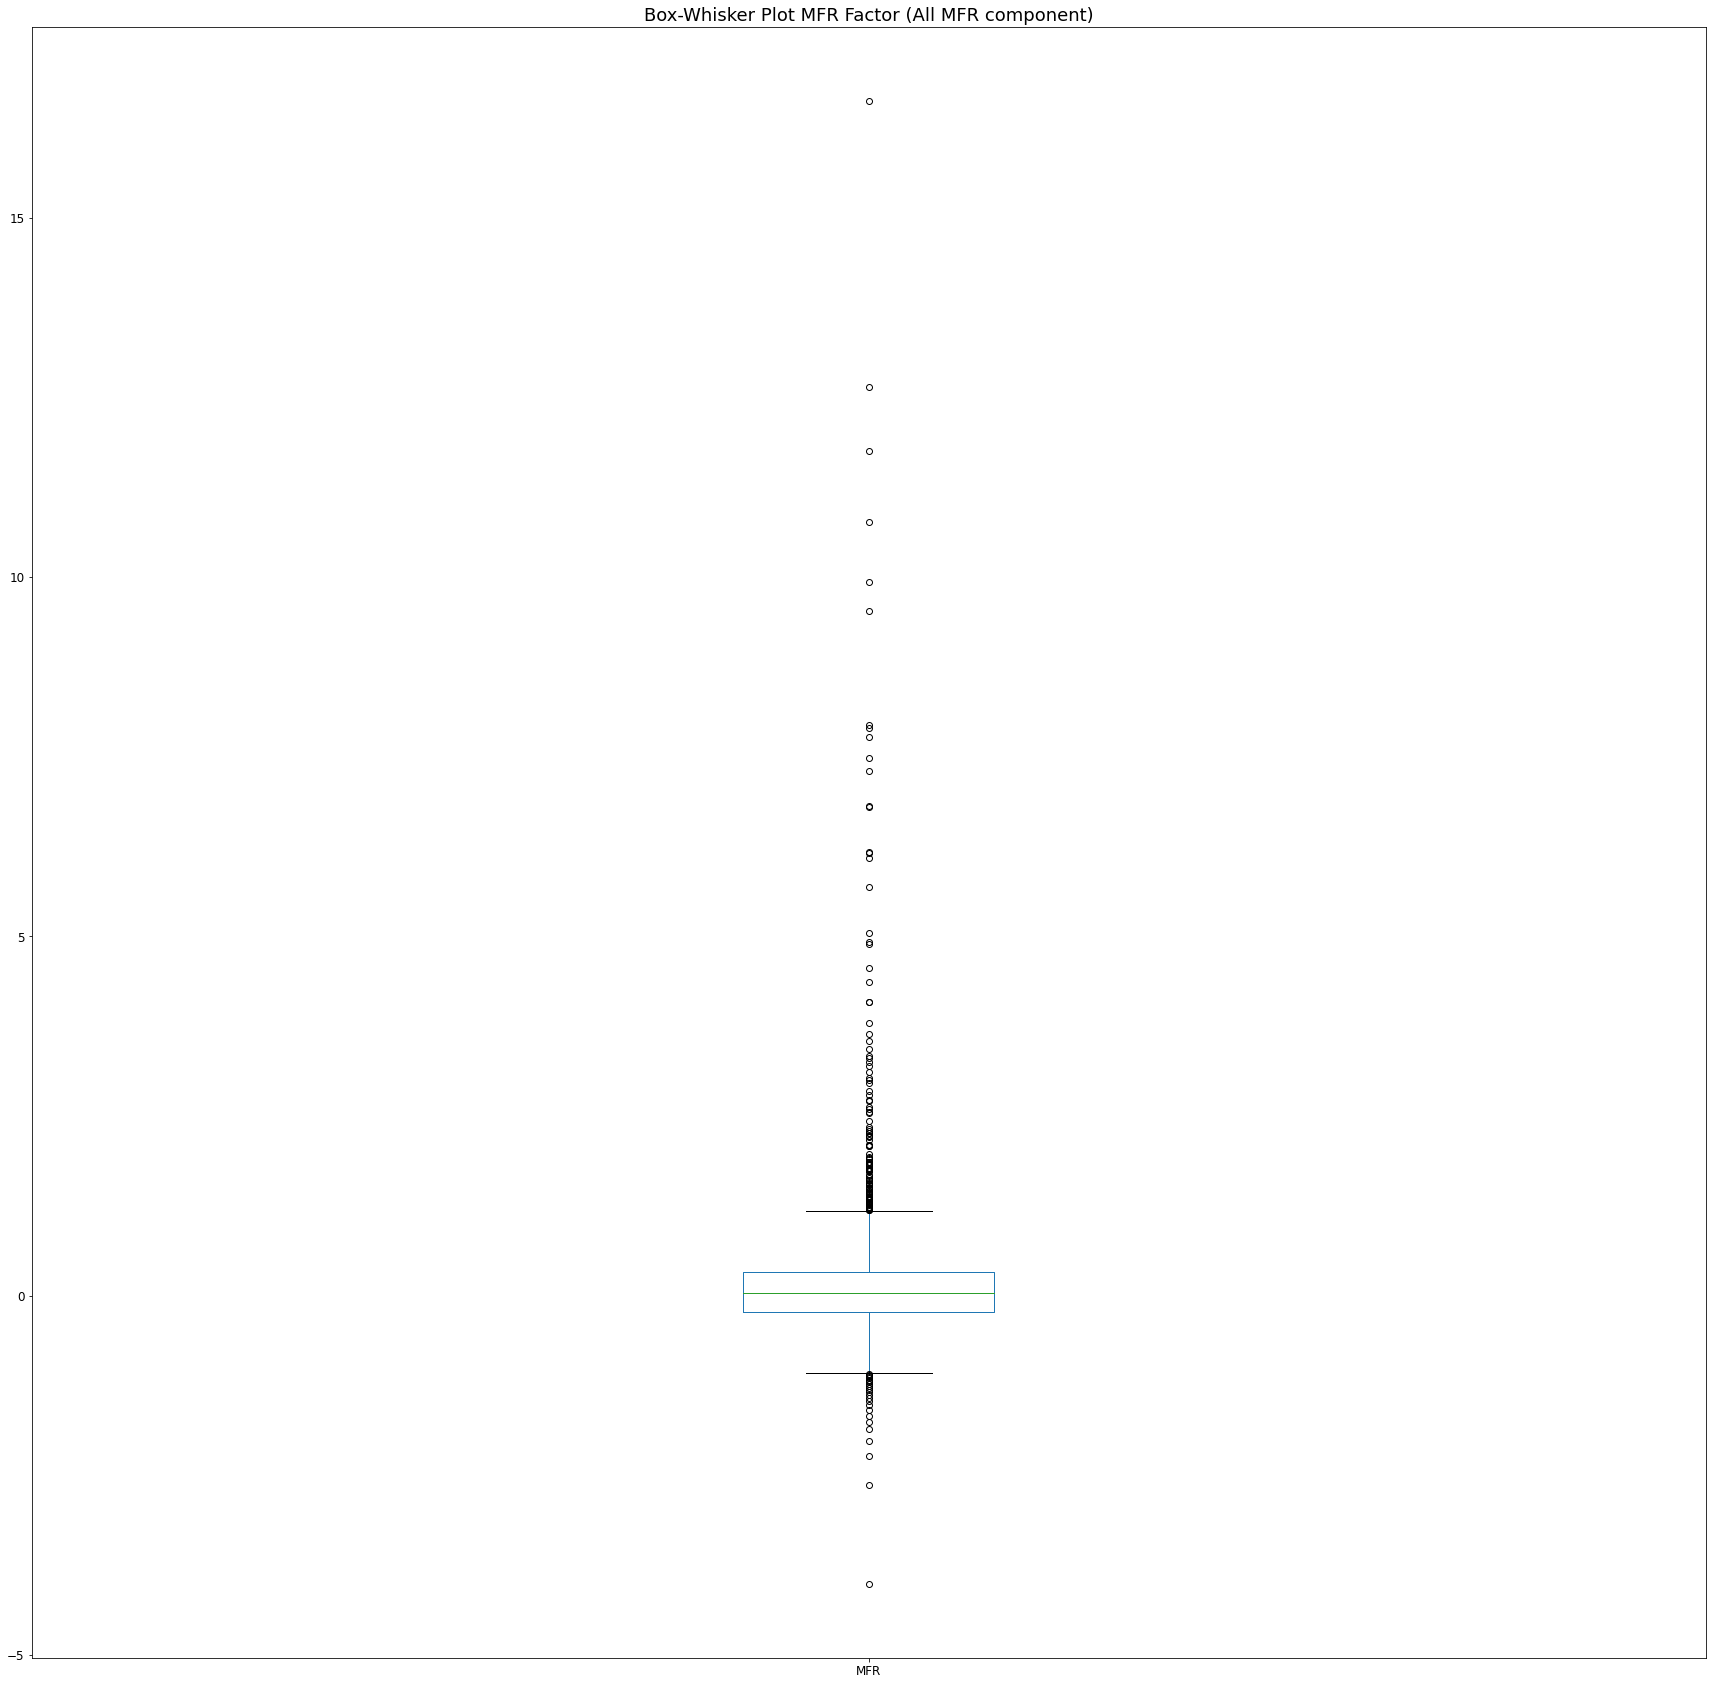

In [23]:
pd.DataFrame(qfl_df_z['MFR']).boxplot(grid=False, fontsize=12, figsize = (30,30)).set_title('Box-Whisker Plot MFR Factor (All MFR component)', fontsize = 18);

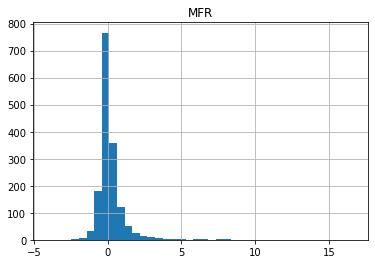

In [24]:
# MFR Distribution

pd.DataFrame(qfl_df_z['MFR']).hist(bins = int(np.sqrt(len(qfl_df_z['MFR']))));

In [25]:
# Check Infomation Coefficient: MFR (Components: All, Z-Scored Only)

sp_corr_z, sp_pval_z = stats.spearmanr(-qfl_df_z['MFR'].replace(np.nan, 0), qfl_df['p_total_return'].replace(np.nan, 0))
print('Information Coefficient: {0}'.format(round(sp_corr_z,2)))
print('Information Coefficient (P-Value): {0}'.format(round(sp_pval_z,2)))

Information Coefficient: 0.05
Information Coefficient (P-Value): 0.07


C:\Users\ffais\Anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


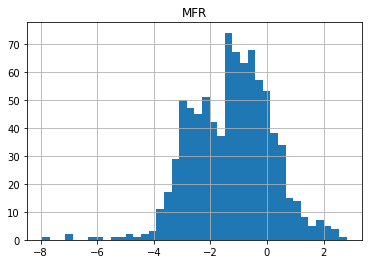

In [26]:
# MFR Log-Distribution

pd.DataFrame(np.log(qfl_df_z['MFR'])).hist(bins = int(np.sqrt(len(qfl_df_z['MFR']))));

In [27]:
# Log-Transformation for positive/not-zero features

qfl_df_log = pd.DataFrame()

for col_pos in qfl_df[qfl_df.columns[filter_idx]]:
    if np.sum(qfl_df[qfl_df.columns[filter_idx]][col_pos] <= 0) == 0:
        qfl_df_log[col_pos] = np.log(qfl_df[qfl_df.columns[filter_idx]][col_pos])
    else:
        qfl_df_log[col_pos] = qfl_df[qfl_df.columns[filter_idx]][col_pos]
    
qfl_df_log

,"QFL_MKT_SHR_GR(0,ECON,LT)","QFL_MKT_SHR_GR(0,ECON,5YR)","QFL_MKT_SHR_GR(0,ECON,4YR)","QFL_MKT_SHR_GR(0,ECON,3YR)","QFL_MKT_SHR_GR(0,ECON,2YR)","QFL_MKT_SHR_GR(0,ECON,1YR)","QFL_MKT_SHR_GR(0,ECON,5YR_FWD)","QFL_MKT_SHR_GR(0,ECON,4YR_FWD)","QFL_MKT_SHR_GR(0,ECON,3YR_FWD)","QFL_MKT_SHR_GR(0,ECON,2YR_FWD)","QFL_MKT_SHR_GR(0,ECON,1YR_FWD)","QFL_MKT_SHR_GR(0,SECT,LT)","QFL_MKT_SHR_GR(0,SECT,5YR)","QFL_MKT_SHR_GR(0,SECT,4YR)","QFL_MKT_SHR_GR(0,SECT,3YR)","QFL_MKT_SHR_GR(0,SECT,2YR)","QFL_MKT_SHR_GR(0,SECT,1YR)","QFL_MKT_SHR_GR(0,SECT,5YR_FWD)","QFL_MKT_SHR_GR(0,SECT,4YR_FWD)","QFL_MKT_SHR_GR(0,SECT,3YR_FWD)","QFL_MKT_SHR_GR(0,SECT,2YR_FWD)","QFL_MKT_SHR_GR(0,SECT,1YR_FWD)","QFL_MKT_SHR_GR(0,SUBSECT,LT)","QFL_MKT_SHR_GR(0,SUBSECT,5YR)","QFL_MKT_SHR_GR(0,SUBSECT,4YR)","QFL_MKT_SHR_GR(0,SUBSECT,3YR)","QFL_MKT_SHR_GR(0,SUBSECT,2YR)","QFL_MKT_SHR_GR(0,SUBSECT,1YR)","QFL_MKT_SHR_GR(0,SUBSECT,5YR_FWD)","QFL_MKT_SHR_GR(0,SUBSECT,4YR_FWD)","QFL_MKT_SHR_GR(0,SUBSECT,3YR_FWD)","QFL_MKT_SHR_GR(0,SUBSECT,2YR_FWD)","QFL_MKT_SHR_GR(0,SUBSECT,1YR_FWD)","QFL_MKT_SHR_GR(0,INDGRP,LT)","QFL_MKT_SHR_GR(0,INDGRP,5YR)","QFL_MKT_SHR_GR(0,INDGRP,4YR)","QFL_MKT_SHR_GR(0,INDGRP,3YR)","QFL_MKT_SHR_GR(0,INDGRP,2YR)","QFL_MKT_SHR_GR(0,INDGRP,1YR)","QFL_MKT_SHR_GR(0,INDGRP,5YR_FWD)","QFL_MKT_SHR_GR(0,INDGRP,4YR_FWD)","QFL_MKT_SHR_GR(0,INDGRP,3YR_FWD)","QFL_MKT_SHR_GR(0,INDGRP,2YR_FWD)","QFL_MKT_SHR_GR(0,INDGRP,1YR_FWD)","QFL_SALES_GR(0,LT)","QFL_SALES_GR(0,5YR)","QFL_SALES_GR(0,4YR)","QFL_SALES_GR(0,3YR)","QFL_SALES_GR(0,2YR)","QFL_SALES_GR(0,1YR)","QFL_SALES_GR(0,5YR_FWD)","QFL_SALES_GR(0,4YR_FWD)","QFL_SALES_GR(0,3YR_FWD)","QFL_SALES_GR(0,2YR_FWD)","QFL_SALES_GR(0,1YR_FWD)","QFL_EBIT_GR(0,LT)","QFL_EBIT_GR(0,5YR)","QFL_EBIT_GR(0,4YR)","QFL_EBIT_GR(0,3YR)","QFL_EBIT_GR(0,2YR)","QFL_EBIT_GR(0,1YR)","QFL_EBIT_GR(0,5YR_FWD)","QFL_EBIT_GR(0,4YR_FWD)","QFL_EBIT_GR(0,3YR_FWD)","QFL_EBIT_GR(0,2YR_FWD)","QFL_EBIT_GR(0,1YR_FWD)","QFL_EBITDA_GR(0,LT)","QFL_EBITDA_GR(0,5YR)","QFL_EBITDA_GR(0,4YR)","QFL_EBITDA_GR(0,3YR)","QFL_EBITDA_GR(0,2YR)","QFL_EBITDA_GR(0,1YR)","QFL_EBITDA_GR(0,5YR_FWD)","QFL_EBITDA_GR(0,4YR_FWD)","QFL_EBITDA_GR(0,3YR_FWD)","QFL_EBITDA_GR(0,2YR_FWD)","QFL_EBITDA_GR(0,1YR_FWD)","QFL_NET_INC_GR(0,LT)","QFL_NET_INC_GR(0,5YR)","QFL_NET_INC_GR(0,4YR)","QFL_NET_INC_GR(0,3YR)","QFL_NET_INC_GR(0,2YR)","QFL_NET_INC_GR(0,1YR)","QFL_NET_INC_GR(0,5YR_FWD)","QFL_NET_INC_GR(0,4YR_FWD)","QFL_NET_INC_GR(0,3YR_FWD)","QFL_NET_INC_GR(0,2YR_FWD)","QFL_NET_INC_GR(0,1YR_FWD)","QFL_EPS_GR(0,LT)","QFL_EPS_GR(0,5YR)","QFL_EPS_GR(0,4YR)","QFL_EPS_GR(0,3YR)","QFL_EPS_GR(0,2YR)","QFL_EPS_GR(0,1YR)","QFL_EPS_GR(0,5YR_FWD)","QFL_EPS_GR(0,4YR_FWD)","QFL_EPS_GR(0,3YR_FWD)","QFL_EPS_GR(0,2YR_FWD)","QFL_EPS_GR(0,1YR_FWD)","QFL_OCF_GR(0,LT)","QFL_OCF_GR(0,5YR)","QFL_OCF_GR(0,4YR)","QFL_OCF_GR(0,3YR)","QFL_OCF_GR(0,2YR)","QFL_OCF_GR(0,1YR)","QFL_OCF_GR(0,5YR_FWD)","QFL_OCF_GR(0,4YR_FWD)","QFL_OCF_GR(0,3YR_FWD)","QFL_OCF_GR(0,2YR_FWD)","QFL_OCF_GR(0,1YR_FWD)","QFL_FCF_GR(0,LT)","QFL_FCF_GR(0,5YR)","QFL_FCF_GR(0,4YR)","QFL_FCF_GR(0,3YR)","QFL_FCF_GR(0,2YR)","QFL_FCF_GR(0,1YR)","QFL_FCF_GR(0,5YR_FWD)","QFL_FCF_GR(0,4YR_FWD)","QFL_FCF_GR(0,3YR_FWD)","QFL_FCF_GR(0,2YR_FWD)","QFL_FCF_GR(0,1YR_FWD)","QFL_DPS_GR(0,LT)","QFL_DPS_GR(0,5YR)","QFL_DPS_GR(0,4YR)","QFL_DPS_GR(0,3YR)","QFL_DPS_GR(0,2YR)","QFL_DPS_GR(0,1YR)","QFL_DPS_GR(0,5YR_FWD)","QFL_DPS_GR(0,4YR_FWD)","QFL_DPS_GR(0,3YR_FWD)","QFL_DPS_GR(0,2YR_FWD)","QFL_DPS_GR(0,1YR_FWD)",QFL_LTG(0),QFL_STABLE_SALES_GR(0),QFL_STABLE_EBIT_GR(0),QFL_STABLE_EBITDA_GR(0),QFL_STABLE_NET_INC_GR(0),QFL_STABLE_EPS_GR(0),QFL_STABLE_OCF_GR(0),QFL_STABLE_FCF_GR(0),QFL_STABLE_DPS_GR(0),"QFL_RD_SALES(0,CT)","QFL_RD_SALES(0,NTM)","QFL_RD_SALES(0,FY1)","QFL_RD_SALES(0,FY2)","QFL_RD_BV(0,CT)","QFL_RD_BV(0,FY1)","QFL_RD_BV(0,FY2)","QFL_RD_MV(0,CT)","QFL_RD_MV(0,NTM)","QFL_RD_MV(0,FY1)","QFL_RD_MV(0,FY2)","QFL_CFI_SALES(0,CT)","QFL_CFI_SALES(0,NTM)","QFL_CFI_SALES(0,FY1)","QFL_CFI_SALES(0,FY2)","QFL_CFI_BV(0,CT)","QFL_CFI_BV(0,FY1)","QFL_CFI_BV(0,FY2)","QFL_CFI_MV(0

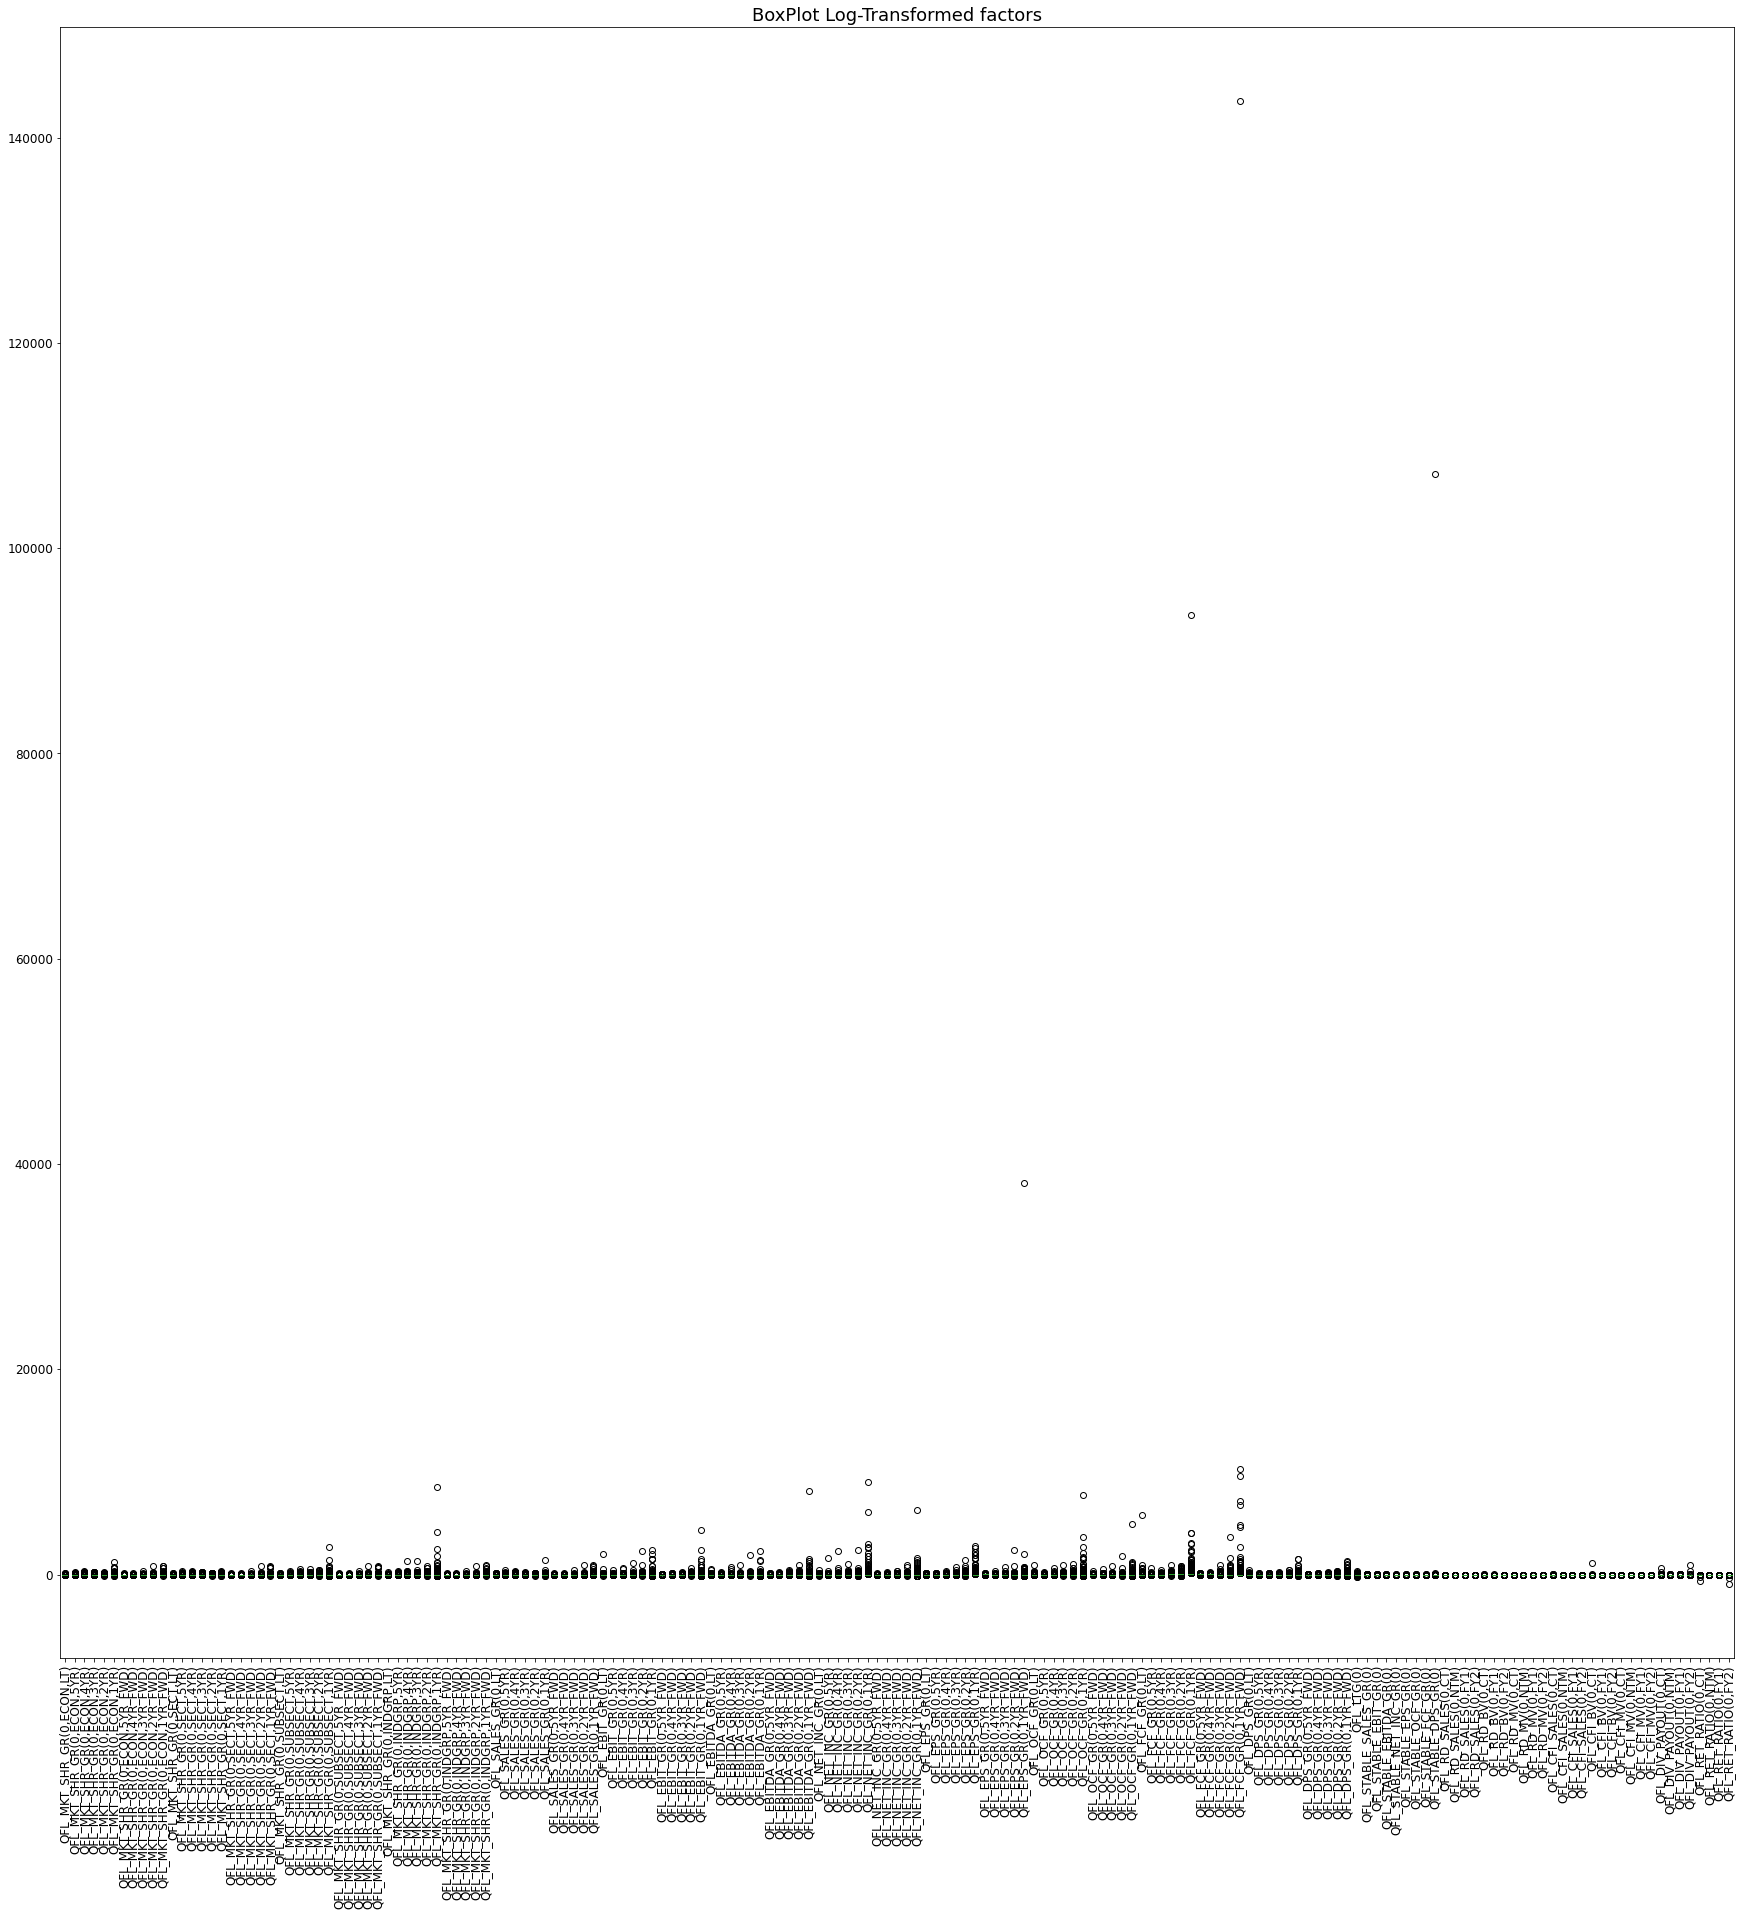

In [28]:
# Box-Whisker plot of Log-Transformed data

qfl_df_log.boxplot(grid=False, rot=90, fontsize=12, figsize = (30,30)).set_title('BoxPlot Log-Transformed factors', fontsize = 18);

In [29]:
# MFR Z-Score of Log-Transformed and Z-Scored data

# Z-Score of Log-Transformed data

qfl_df_log_z = pd.DataFrame()

for factor in qfl_df_log:
    z_score = ( qfl_df_log[factor] - qfl_df_log[factor].mean() ) / qfl_df_log[factor].std()
    qfl_df_log_z[factor] = z_score

qfl_df_log_z['MFR'] = qfl_df_log_z.mean(axis = 1)

qfl_df_log_z.head()

,"QFL_MKT_SHR_GR(0,ECON,LT)","QFL_MKT_SHR_GR(0,ECON,5YR)","QFL_MKT_SHR_GR(0,ECON,4YR)","QFL_MKT_SHR_GR(0,ECON,3YR)","QFL_MKT_SHR_GR(0,ECON,2YR)","QFL_MKT_SHR_GR(0,ECON,1YR)","QFL_MKT_SHR_GR(0,ECON,5YR_FWD)","QFL_MKT_SHR_GR(0,ECON,4YR_FWD)","QFL_MKT_SHR_GR(0,ECON,3YR_FWD)","QFL_MKT_SHR_GR(0,ECON,2YR_FWD)","QFL_MKT_SHR_GR(0,ECON,1YR_FWD)","QFL_MKT_SHR_GR(0,SECT,LT)","QFL_MKT_SHR_GR(0,SECT,5YR)","QFL_MKT_SHR_GR(0,SECT,4YR)","QFL_MKT_SHR_GR(0,SECT,3YR)","QFL_MKT_SHR_GR(0,SECT,2YR)","QFL_MKT_SHR_GR(0,SECT,1YR)","QFL_MKT_SHR_GR(0,SECT,5YR_FWD)","QFL_MKT_SHR_GR(0,SECT,4YR_FWD)","QFL_MKT_SHR_GR(0,SECT,3YR_FWD)","QFL_MKT_SHR_GR(0,SECT,2YR_FWD)","QFL_MKT_SHR_GR(0,SECT,1YR_FWD)","QFL_MKT_SHR_GR(0,SUBSECT,LT)","QFL_MKT_SHR_GR(0,SUBSECT,5YR)","QFL_MKT_SHR_GR(0,SUBSECT,4YR)","QFL_MKT_SHR_GR(0,SUBSECT,3YR)","QFL_MKT_SHR_GR(0,SUBSECT,2YR)","QFL_MKT_SHR_GR(0,SUBSECT,1YR)","QFL_MKT_SHR_GR(0,SUBSECT,5YR_FWD)","QFL_MKT_SHR_GR(0,SUBSECT,4YR_FWD)","QFL_MKT_SHR_GR(0,SUBSECT,3YR_FWD)","QFL_MKT_SHR_GR(0,SUBSECT,2YR_FWD)","QFL_MKT_SHR_GR(0,SUBSECT,1YR_FWD)","QFL_MKT_SHR_GR(0,INDGRP,LT)","QFL_MKT_SHR_GR(0,INDGRP,5YR)","QFL_MKT_SHR_GR(0,INDGRP,4YR)","QFL_MKT_SHR_GR(0,INDGRP,3YR)","QFL_MKT_SHR_GR(0,INDGRP,2YR)","QFL_MKT_SHR_GR(0,INDGRP,1YR)","QFL_MKT_SHR_GR(0,INDGRP,5YR_FWD)","QFL_MKT_SHR_GR(0,INDGRP,4YR_FWD)","QFL_MKT_SHR_GR(0,INDGRP,3YR_FWD)","QFL_MKT_SHR_GR(0,INDGRP,2YR_FWD)","QFL_MKT_SHR_GR(0,INDGRP,1YR_FWD)","QFL_SALES_GR(0,LT)","QFL_SALES_GR(0,5YR)","QFL_SALES_GR(0,4YR)","QFL_SALES_GR(0,3YR)","QFL_SALES_GR(0,2YR)","QFL_SALES_GR(0,1YR)","QFL_SALES_GR(0,5YR_FWD)","QFL_SALES_GR(0,4YR_FWD)","QFL_SALES_GR(0,3YR_FWD)","QFL_SALES_GR(0,2YR_FWD)","QFL_SALES_GR(0,1YR_FWD)","QFL_EBIT_GR(0,LT)","QFL_EBIT_GR(0,5YR)","QFL_EBIT_GR(0,4YR)","QFL_EBIT_GR(0,3YR)","QFL_EBIT_GR(0,2YR)","QFL_EBIT_GR(0,1YR)","QFL_EBIT_GR(0,5YR_FWD)","QFL_EBIT_GR(0,4YR_FWD)","QFL_EBIT_GR(0,3YR_FWD)","QFL_EBIT_GR(0,2YR_FWD)","QFL_EBIT_GR(0,1YR_FWD)","QFL_EBITDA_GR(0,LT)","QFL_EBITDA_GR(0,5YR)","QFL_EBITDA_GR(0,4YR)","QFL_EBITDA_GR(0,3YR)","QFL_EBITDA_GR(0,2YR)","QFL_EBITDA_GR(0,1YR)","QFL_EBITDA_GR(0,5YR_FWD)","QFL_EBITDA_GR(0,4YR_FWD)","QFL_EBITDA_GR(0,3YR_FWD)","QFL_EBITDA_GR(0,2YR_FWD)","QFL_EBITDA_GR(0,1YR_FWD)","QFL_NET_INC_GR(0,LT)","QFL_NET_INC_GR(0,5YR)","QFL_NET_INC_GR(0,4YR)","QFL_NET_INC_GR(0,3YR)","QFL_NET_INC_GR(0,2YR)","QFL_NET_INC_GR(0,1YR)","QFL_NET_INC_GR(0,5YR_FWD)","QFL_NET_INC_GR(0,4YR_FWD)","QFL_NET_INC_GR(0,3YR_FWD)","QFL_NET_INC_GR(0,2YR_FWD)","QFL_NET_INC_GR(0,1YR_FWD)","QFL_EPS_GR(0,LT)","QFL_EPS_GR(0,5YR)","QFL_EPS_GR(0,4YR)","QFL_EPS_GR(0,3YR)","QFL_EPS_GR(0,2YR)","QFL_EPS_GR(0,1YR)","QFL_EPS_GR(0,5YR_FWD)","QFL_EPS_GR(0,4YR_FWD)","QFL_EPS_GR(0,3YR_FWD)","QFL_EPS_GR(0,2YR_FWD)","QFL_EPS_GR(0,1YR_FWD)","QFL_OCF_GR(0,LT)","QFL_OCF_GR(0,5YR)","QFL_OCF_GR(0,4YR)","QFL_OCF_GR(0,3YR)","QFL_OCF_GR(0,2YR)","QFL_OCF_GR(0,1YR)","QFL_OCF_GR(0,5YR_FWD)","QFL_OCF_GR(0,4YR_FWD)","QFL_OCF_GR(0,3YR_FWD)","QFL_OCF_GR(0,2YR_FWD)","QFL_OCF_GR(0,1YR_FWD)","QFL_FCF_GR(0,LT)","QFL_FCF_GR(0,5YR)","QFL_FCF_GR(0,4YR)","QFL_FCF_GR(0,3YR)","QFL_FCF_GR(0,2YR)","QFL_FCF_GR(0,1YR)","QFL_FCF_GR(0,5YR_FWD)","QFL_FCF_GR(0,4YR_FWD)","QFL_FCF_GR(0,3YR_FWD)","QFL_FCF_GR(0,2YR_FWD)","QFL_FCF_GR(0,1YR_FWD)","QFL_DPS_GR(0,LT)","QFL_DPS_GR(0,5YR)","QFL_DPS_GR(0,4YR)","QFL_DPS_GR(0,3YR)","QFL_DPS_GR(0,2YR)","QFL_DPS_GR(0,1YR)","QFL_DPS_GR(0,5YR_FWD)","QFL_DPS_GR(0,4YR_FWD)","QFL_DPS_GR(0,3YR_FWD)","QFL_DPS_GR(0,2YR_FWD)","QFL_DPS_GR(0,1YR_FWD)",QFL_LTG(0),QFL_STABLE_SALES_GR(0),QFL_STABLE_EBIT_GR(0),QFL_STABLE_EBITDA_GR(0),QFL_STABLE_NET_INC_GR(0),QFL_STABLE_EPS_GR(0),QFL_STABLE_OCF_GR(0),QFL_STABLE_FCF_GR(0),QFL_STABLE_DPS_GR(0),"QFL_RD_SALES(0,CT)","QFL_RD_SALES(0,NTM)","QFL_RD_SALES(0,FY1)","QFL_RD_SALES(0,FY2)","QFL_RD_BV(0,CT)","QFL_RD_BV(0,FY1)","QFL_RD_BV(0,FY2)","QFL_RD_MV(0,CT)","QFL_RD_MV(0,NTM)","QFL_RD_MV(0,FY1)","QFL_RD_MV(0,FY2)","QFL_CFI_SALES(0,CT)","QFL_CFI_SALES(0,NTM)","QFL_CFI_SALES(0,FY1)","QFL_CFI_SALES(0,FY2)","QFL_CFI_BV(0,CT)","QFL_CFI_BV(0,FY1)","QFL_CFI_BV(0,FY2)","QFL_CFI_MV(0

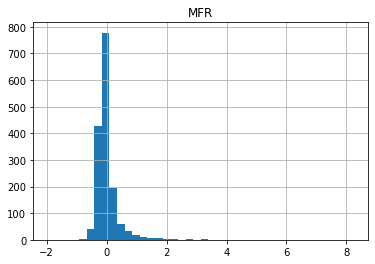

In [30]:
# MFR Distribution (of Log-Transformed and Z-Score factors)

pd.DataFrame(qfl_df_log_z['MFR']).hist(bins = int(np.sqrt(len(qfl_df_log_z['MFR']))));

In [31]:
# Check Infomation Coefficient: MRF (Components: All, Z-Scored & Log-Transformed)

sp_corr_z_log, sp_pval_z_log = stats.spearmanr(-qfl_df_log_z['MFR'].replace(np.nan, 0), qfl_df['p_total_return'].replace(np.nan, 0))
print('Information Coefficient: {0}'.format(round(sp_corr_z_log,2)))
print('Information Coefficient (P-Value): {0}'.format(round(sp_pval_z_log,2)))

Information Coefficient: -0.05
Information Coefficient (P-Value): 0.03


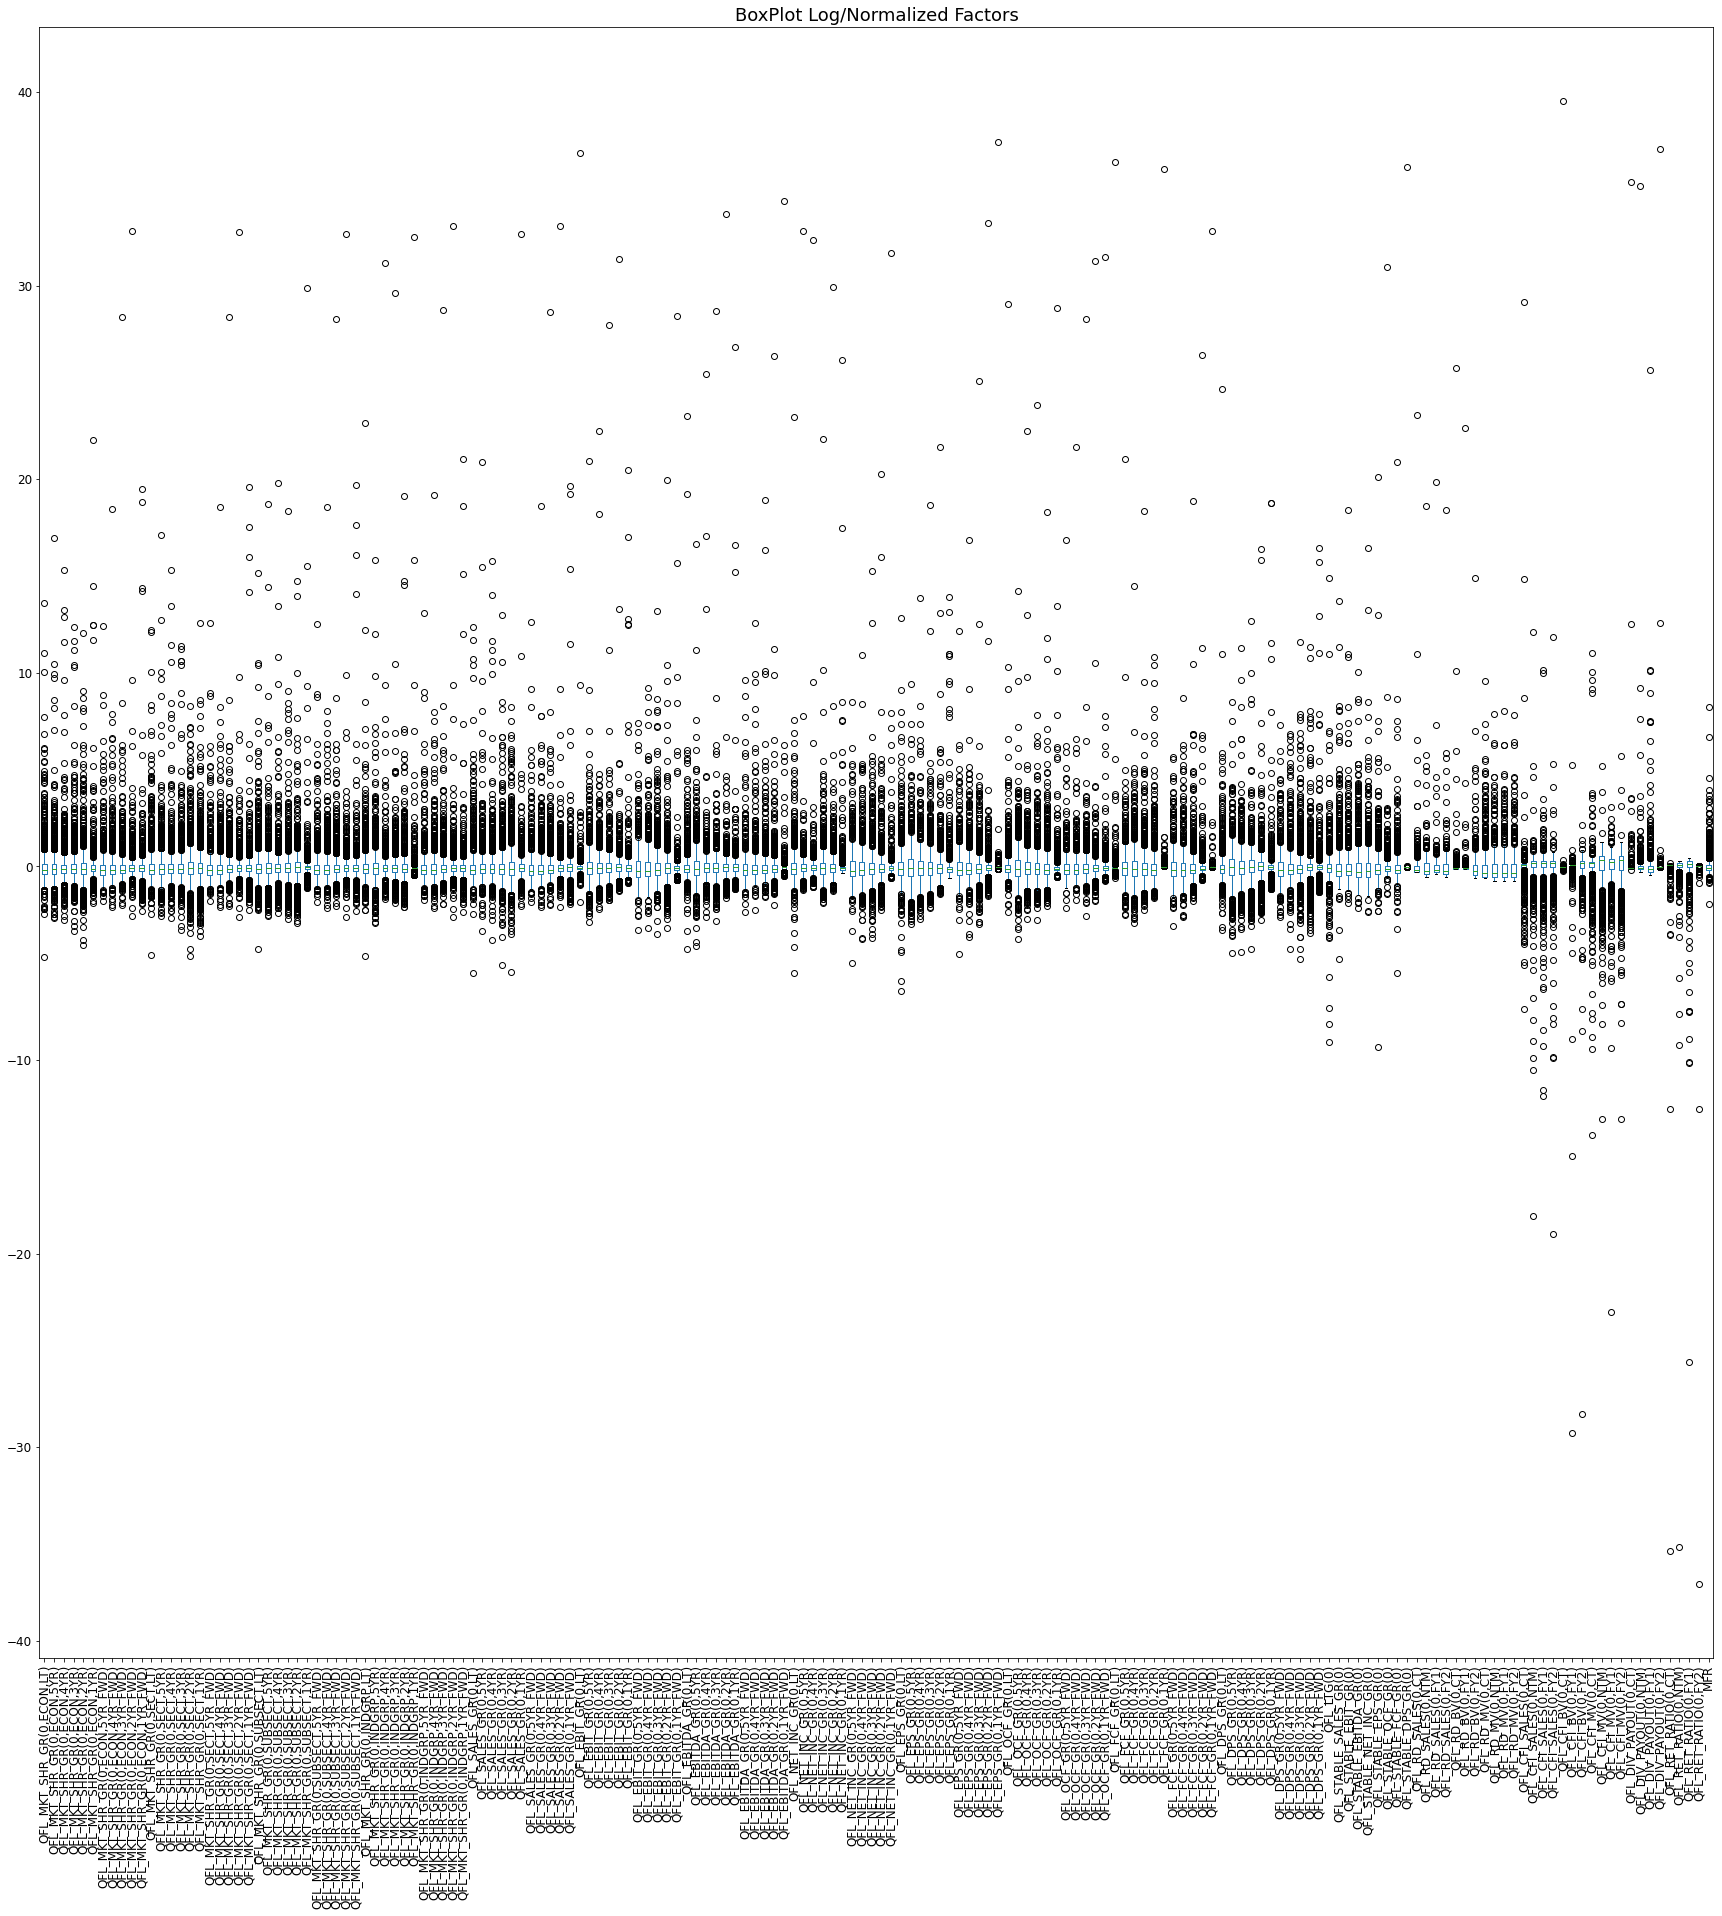

In [32]:
# Box-Whisker plot of Log-Transformed and Z-Score data

qfl_df_log_z.boxplot(grid=False, rot=90, fontsize=12, figsize = (30,30)).set_title('BoxPlot Log/Normalized Factors', fontsize = 18);

In [33]:
# Check Universe Exposures (Geography, Size, Sector)

qfl_df['ison_screen'] = 1

qfl_df.head()

,BENCHMARK_ID,DATE,SECURITY_ID,Weight,proper_name,fg_gics_sector,proper,p_total_return,qfl_size_class,qfl_mkt_val_sec,"QFL_MKT_SHR_GR(0,ECON,LT)","QFL_MKT_SHR_GR(0,ECON,5YR)","QFL_MKT_SHR_GR(0,ECON,4YR)","QFL_MKT_SHR_GR(0,ECON,3YR)","QFL_MKT_SHR_GR(0,ECON,2YR)","QFL_MKT_SHR_GR(0,ECON,1YR)","QFL_MKT_SHR_GR(0,ECON,5YR_FWD)","QFL_MKT_SHR_GR(0,ECON,4YR_FWD)","QFL_MKT_SHR_GR(0,ECON,3YR_FWD)","QFL_MKT_SHR_GR(0,ECON,2YR_FWD)","QFL_MKT_SHR_GR(0,ECON,1YR_FWD)","QFL_MKT_SHR_GR(0,SECT,LT)","QFL_MKT_SHR_GR(0,SECT,5YR)","QFL_MKT_SHR_GR(0,SECT,4YR)","QFL_MKT_SHR_GR(0,SECT,3YR)","QFL_MKT_SHR_GR(0,SECT,2YR)","QFL_MKT_SHR_GR(0,SECT,1YR)","QFL_MKT_SHR_GR(0,SECT,5YR_FWD)","QFL_MKT_SHR_GR(0,SECT,4YR_FWD)","QFL_MKT_SHR_GR(0,SECT,3YR_FWD)","QFL_MKT_SHR_GR(0,SECT,2YR_FWD)","QFL_MKT_SHR_GR(0,SECT,1YR_FWD)","QFL_MKT_SHR_GR(0,SUBSECT,LT)","QFL_MKT_SHR_GR(0,SUBSECT,5YR)","QFL_MKT_SHR_GR(0,SUBSECT,4YR)","QFL_MKT_SHR_GR(0,SUBSECT,3YR)","QFL_MKT_SHR_GR(0,SUBSECT,2YR)","QFL_MKT_SHR_GR(0,SUBSECT,1YR)","QFL_MKT_SHR_GR(0,SUBSECT,5YR_FWD)","QFL_MKT_SHR_GR(0,SUBSECT,4YR_FWD)","QFL_MKT_SHR_GR(0,SUBSECT,3YR_FWD)","QFL_MKT_SHR_GR(0,SUBSECT,2YR_FWD)","QFL_MKT_SHR_GR(0,SUBSECT,1YR_FWD)","QFL_MKT_SHR_GR(0,INDGRP,LT)","QFL_MKT_SHR_GR(0,INDGRP,5YR)","QFL_MKT_SHR_GR(0,INDGRP,4YR)","QFL_MKT_SHR_GR(0,INDGRP,3YR)","QFL_MKT_SHR_GR(0,INDGRP,2YR)","QFL_MKT_SHR_GR(0,INDGRP,1YR)","QFL_MKT_SHR_GR(0,INDGRP,5YR_FWD)","QFL_MKT_SHR_GR(0,INDGRP,4YR_FWD)","QFL_MKT_SHR_GR(0,INDGRP,3YR_FWD)","QFL_MKT_SHR_GR(0,INDGRP,2YR_FWD)","QFL_MKT_SHR_GR(0,INDGRP,1YR_FWD)","QFL_SALES_GR(0,LT)","QFL_SALES_GR(0,5YR)","QFL_SALES_GR(0,4YR)","QFL_SALES_GR(0,3YR)","QFL_SALES_GR(0,2YR)","QFL_SALES_GR(0,1YR)","QFL_SALES_GR(0,5YR_FWD)","QFL_SALES_GR(0,4YR_FWD)","QFL_SALES_GR(0,3YR_FWD)","QFL_SALES_GR(0,2YR_FWD)","QFL_SALES_GR(0,1YR_FWD)","QFL_EBIT_GR(0,LT)","QFL_EBIT_GR(0,5YR)","QFL_EBIT_GR(0,4YR)","QFL_EBIT_GR(0,3YR)","QFL_EBIT_GR(0,2YR)","QFL_EBIT_GR(0,1YR)","QFL_EBIT_GR(0,5YR_FWD)","QFL_EBIT_GR(0,4YR_FWD)","QFL_EBIT_GR(0,3YR_FWD)","QFL_EBIT_GR(0,2YR_FWD)","QFL_EBIT_GR(0,1YR_FWD)","QFL_EBITDA_GR(0,LT)","QFL_EBITDA_GR(0,5YR)","QFL_EBITDA_GR(0,4YR)","QFL_EBITDA_GR(0,3YR)","QFL_EBITDA_GR(0,2YR)","QFL_EBITDA_GR(0,1YR)","QFL_EBITDA_GR(0,5YR_FWD)","QFL_EBITDA_GR(0,4YR_FWD)","QFL_EBITDA_GR(0,3YR_FWD)","QFL_EBITDA_GR(0,2YR_FWD)","QFL_EBITDA_GR(0,1YR_FWD)","QFL_NET_INC_GR(0,LT)","QFL_NET_INC_GR(0,5YR)","QFL_NET_INC_GR(0,4YR)","QFL_NET_INC_GR(0,3YR)","QFL_NET_INC_GR(0,2YR)","QFL_NET_INC_GR(0,1YR)","QFL_NET_INC_GR(0,5YR_FWD)","QFL_NET_INC_GR(0,4YR_FWD)","QFL_NET_INC_GR(0,3YR_FWD)","QFL_NET_INC_GR(0,2YR_FWD)","QFL_NET_INC_GR(0,1YR_FWD)","QFL_EPS_GR(0,LT)","QFL_EPS_GR(0,5YR)","QFL_EPS_GR(0,4YR)","QFL_EPS_GR(0,3YR)","QFL_EPS_GR(0,2YR)","QFL_EPS_GR(0,1YR)","QFL_EPS_GR(0,5YR_FWD)","QFL_EPS_GR(0,4YR_FWD)","QFL_EPS_GR(0,3YR_FWD)","QFL_EPS_GR(0,2YR_FWD)","QFL_EPS_GR(0,1YR_FWD)","QFL_OCF_GR(0,LT)","QFL_OCF_GR(0,5YR)","QFL_OCF_GR(0,4YR)","QFL_OCF_GR(0,3YR)","QFL_OCF_GR(0,2YR)","QFL_OCF_GR(0,1YR)","QFL_OCF_GR(0,5YR_FWD)","QFL_OCF_GR(0,4YR_FWD)","QFL_OCF_GR(0,3YR_FWD)","QFL_OCF_GR(0,2YR_FWD)","QFL_OCF_GR(0,1YR_FWD)","QFL_FCF_GR(0,LT)","QFL_FCF_GR(0,5YR)","QFL_FCF_GR(0,4YR)","QFL_FCF_GR(0,3YR)","QFL_FCF_GR(0,2YR)","QFL_FCF_GR(0,1YR)","QFL_FCF_GR(0,5YR_FWD)","QFL_FCF_GR(0,4YR_FWD)","QFL_FCF_GR(0,3YR_FWD)","QFL_FCF_GR(0,2YR_FWD)","QFL_FCF_GR(0,1YR_FWD)","QFL_DPS_GR(0,LT)","QFL_DPS_GR(0,5YR)","QFL_DPS_GR(0,4YR)","QFL_DPS_GR(0,3YR)","QFL_DPS_GR(0,2YR)","QFL_DPS_GR(0,1YR)","QFL_DPS_GR(0,5YR_FWD)","QFL_DPS_GR(0,4YR_FWD)","QFL_DPS_GR(0,3YR_FWD)","QFL_DPS_GR(0,2YR_FWD)","QFL_DPS_GR(0,1YR_FWD)",QFL_LTG(0),QFL_STABLE_SALES_GR(0),QFL_STABLE_EBIT_GR(0),QFL_STABLE_EBITDA_GR(0),QFL_STABLE_NET_INC_GR(0),QFL_STABLE_EPS_GR(0),QFL_STABLE_OCF_GR(0),QFL_STABLE_FCF_GR(0),QFL_STABLE_DPS_GR(0),"QFL_RD_SALES(0,CT)","QFL_RD_SALES(0,NTM)","QFL_RD_SALES(0,FY1)","QFL_RD_SALES(0,FY2)","QFL_RD_BV(0,CT)","QFL_RD_BV(0,FY1)","QFL_RD_BV(0,FY2)","QFL_RD_MV(0,CT)","QFL_RD_MV(0,NTM)","QFL_RD_MV(0,FY1)","QFL_RD_MV(0,FY2)","QFL_CFI_SALES(0,CT)","QFL_CFI_SALES(0,NTM)","

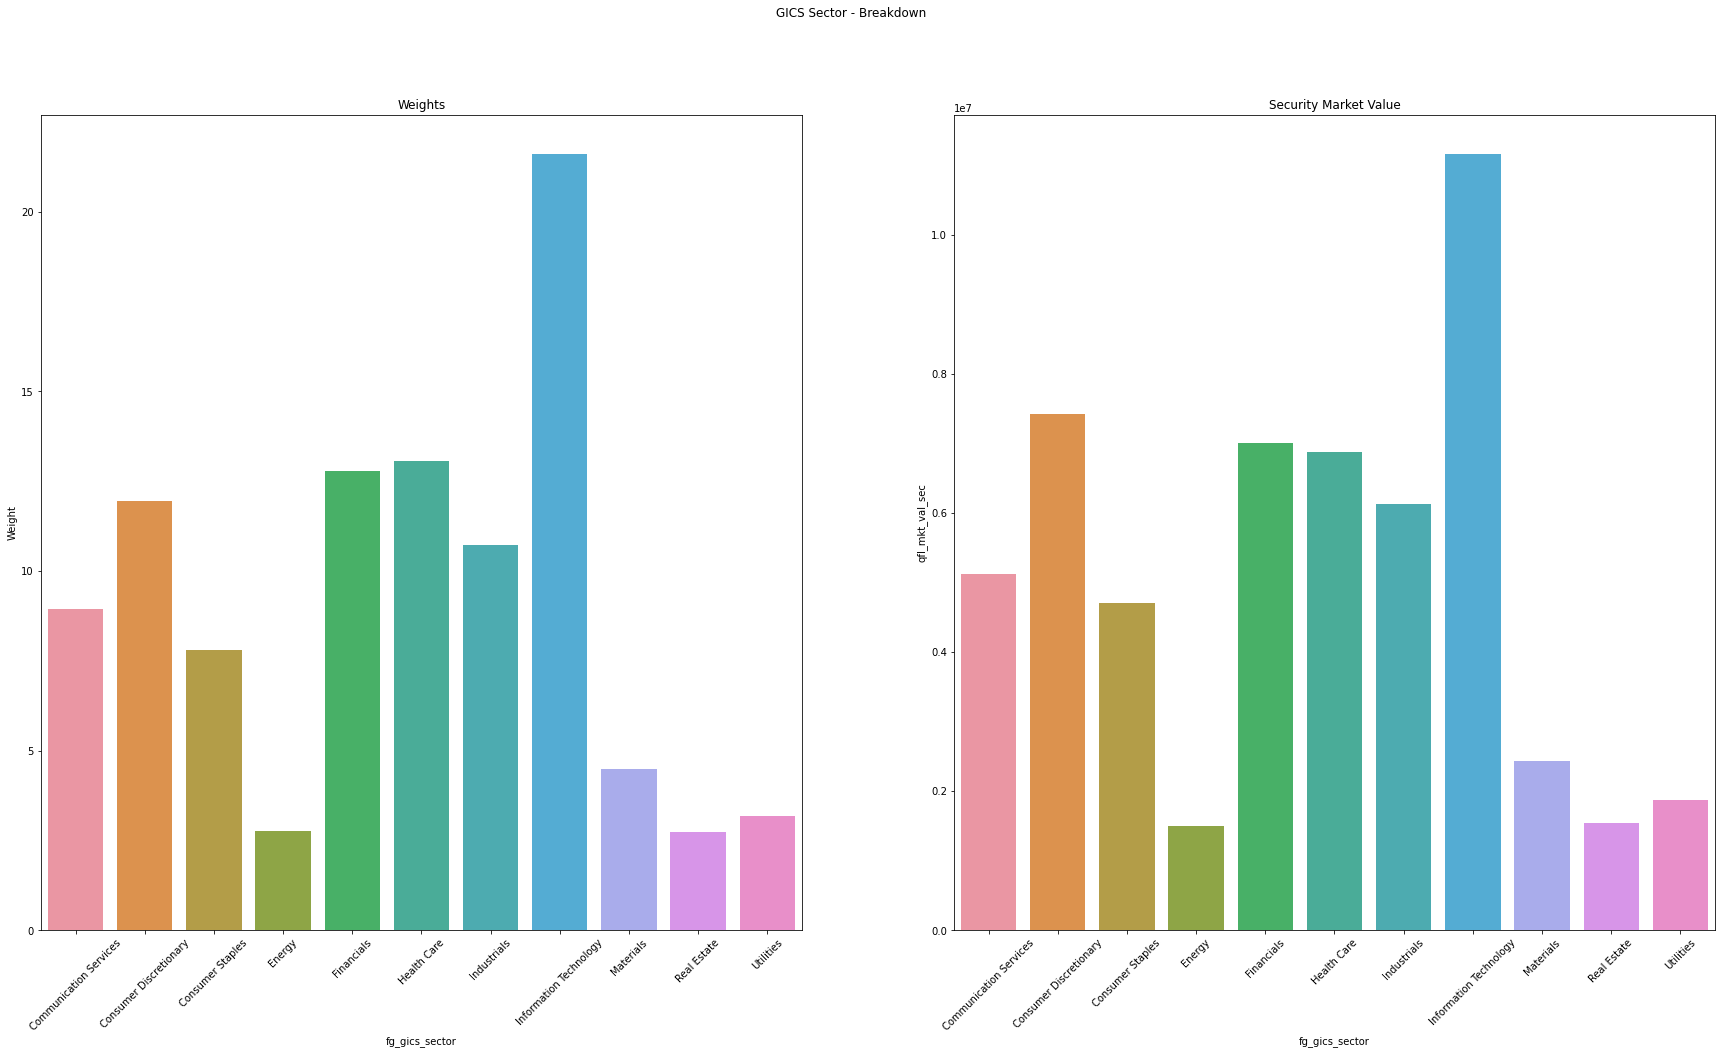

In [34]:
# Group universe

# GICS Sector
GICS_grouped = qfl_df.groupby('fg_gics_sector').sum()

fig, axes = plt.subplots(1, 2, figsize=(30, 15))
fig.suptitle('GICS Sector - Breakdown')
axes[0].set_title('Weights')
axes[1].set_title('Security Market Value')

chart = sns.barplot(ax=axes[0], x = GICS_grouped.index, y = 'Weight', data = GICS_grouped)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
chart = sns.barplot(ax=axes[1], x = GICS_grouped.index, y = 'qfl_mkt_val_sec', data = GICS_grouped)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45);

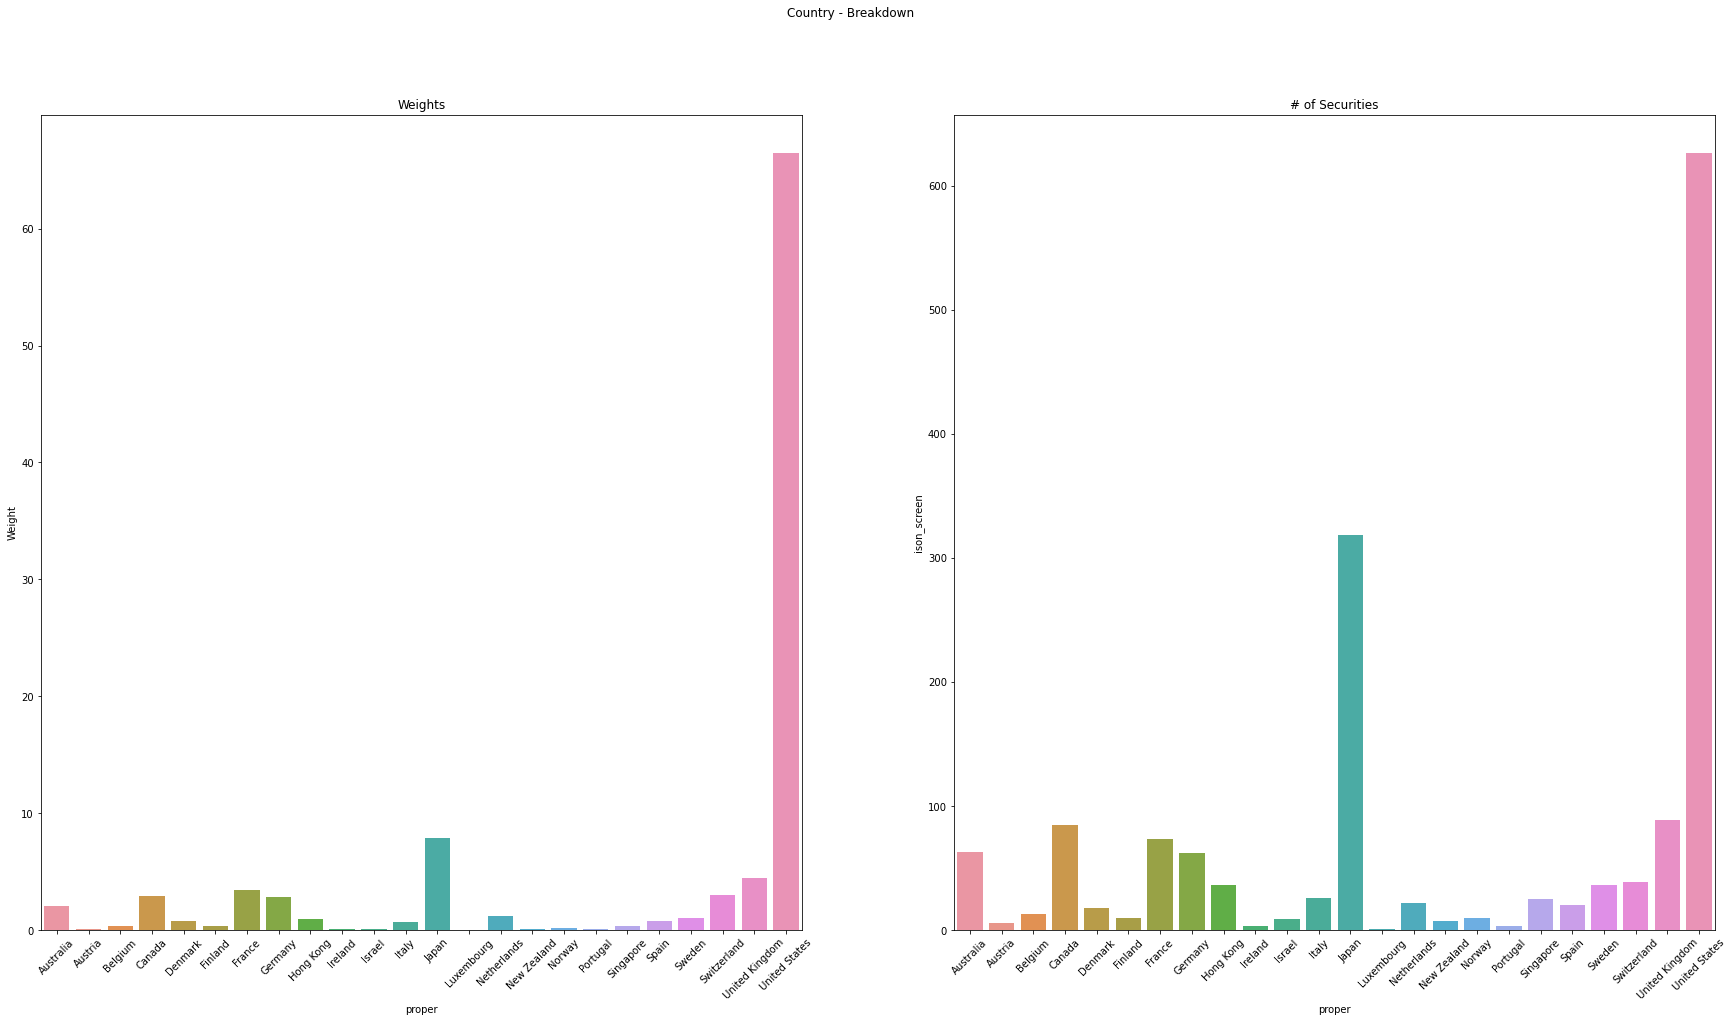

In [35]:
# Group universe

# Country
Country_grouped = qfl_df.groupby('proper').sum()

fig, axes = plt.subplots(1, 2, figsize=(30, 15))
fig.suptitle('Country - Breakdown')
axes[0].set_title('Weights')
axes[1].set_title('# of Securities')

chart = sns.barplot(ax=axes[0], x = Country_grouped.index, y = 'Weight', data = Country_grouped)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
chart = sns.barplot(ax=axes[1], x = Country_grouped.index, y = 'ison_screen', data = Country_grouped)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45);

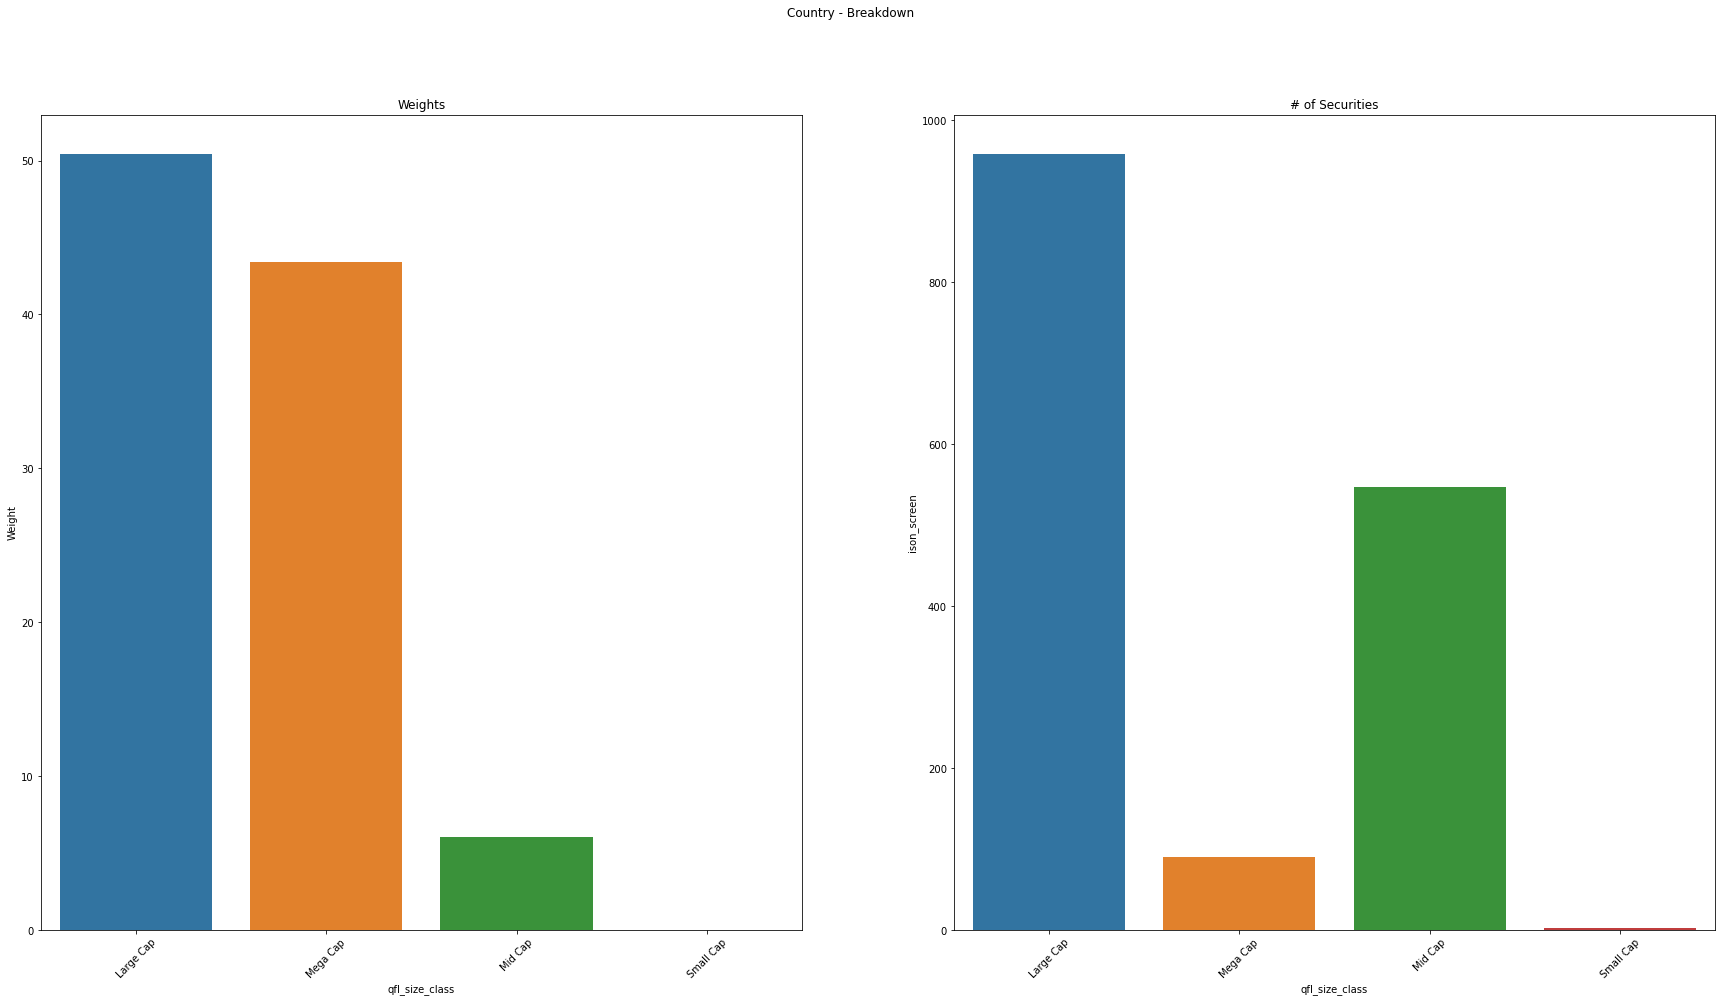

In [36]:
# Group universe

# Size
Size_grouped = qfl_df.groupby('qfl_size_class').sum()

fig, axes = plt.subplots(1, 2, figsize=(30, 15))
fig.suptitle('Country - Breakdown')
axes[0].set_title('Weights')
axes[1].set_title('# of Securities')

chart = sns.barplot(ax=axes[0], x = Size_grouped.index, y = 'Weight', data = Size_grouped)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
chart = sns.barplot(ax=axes[1], x = Size_grouped.index, y = 'ison_screen', data = Size_grouped)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45);

In [37]:
# Feature Selection

In [38]:
# Discard features with more than 80 NAs

qfl_filtered = qfl_df[qfl_df[qfl_df.columns[filter_idx]].isna().sum(axis = 0)[qfl_df[qfl_df.columns[filter_idx]].isna().sum(axis = 0) < 80].index]

In [39]:
# Replace NAs for retained features with feature's average

for col in qfl_filtered.columns:
    qfl_filtered[col] = qfl_filtered[col].replace(np.nan, qfl_filtered[col].mean(axis = 0))
    
qfl_df['p_total_return'] = qfl_df['p_total_return'].replace(np.nan, 0);

<ipython-input-39-d861f91d7765>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qfl_filtered[col] = qfl_filtered[col].replace(np.nan, qfl_filtered[col].mean(axis = 0))


In [40]:
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso

X = qfl_filtered
Y = qfl_df['p_total_return']

#RECURSIVE FEATURE ELIMINATION

lin_reg = Lasso()
rfe = RFE(lin_reg, n_features_to_select=3, step = 1)
fit_rfe = rfe.fit(X, Y)
print("Num Features: %s" % (fit_rfe.n_features_))
print("Selected Features: %s" % (fit_rfe.support_))
print("Feature Ranking: %s" % (fit_rfe.ranking_))


Num Features: 3
Selected Features: [False False False False False False False False False False False False
 False False False False False False False False False False False False
 False  True False False False False False False False False False False
 False False False  True False False False False False False False False
 False  True False False False False False False False False False False]
Feature Ranking: [58 19 42  3  7 34 33 32 31 30 12 49 14  9 55 56 54 18 43  4  5 57 10 25
 35  1 36 38 44 46  6  8 53 39 40 48 50 52 51  1 45 27 11 47 29 15 13 21
 23  1 22 26  2 17 20 37 16 41 24 28]


In [41]:
qfl_filtered.columns[fit_rfe.support_]

Index(['QFL_MKT_SHR_GR(0,SUBSECT,2YR_FWD)', 'QFL_SALES_GR(0,3YR)',
       'QFL_EBITDA_GR(0,3YR)'],
      dtype='object')

In [42]:
qfl_filtered[qfl_filtered.columns[fit_rfe.support_]].corr()

,"QFL_MKT_SHR_GR(0,SUBSECT,2YR_FWD)","QFL_SALES_GR(0,3YR)","QFL_EBITDA_GR(0,3YR)"
"QFL_MKT_SHR_GR(0,SUBSECT,2YR_FWD)",1.000000,0.165361,0.114902
"QFL_SALES_GR(0,3YR)",0.165361,1.000000,0.520318
"QFL_EBITDA_GR(0,3YR)",0.114902,0.520318,1.000000


In [43]:
qfl_filtered[qfl_filtered.columns[fit_rfe.support_]]

,"QFL_MKT_SHR_GR(0,SUBSECT,2YR_FWD)","QFL_SALES_GR(0,3YR)","QFL_EBITDA_GR(0,3YR)"
0,2.881335,4.859805,0.753283
1,-0.766260,15.759861,23.820698
2,17.949354,26.329517,46.857906
3,6.464477,28.582394,17.967106
4,0.813447,18.040573,11.743236
...,...,...,...
1595,-10.506944,1.248729,2.411902
1596,-3.540325,7.332265,-0.283724
1597,-16.023483,-0.545049,-1.550633
1598,-11.251859,-0.870258,18.510874


In [44]:
# MFR Z-Score after Feature Selection

qfl_mfr_RFE = pd.DataFrame()

for factor in qfl_filtered[qfl_filtered.columns[fit_rfe.support_]]:
    z_score_RFE = ( qfl_filtered[factor] - qfl_filtered[factor].mean() ) / qfl_filtered[factor].std()
    qfl_mfr_RFE[factor] = z_score_RFE

qfl_mfr_RFE['MFR'] = qfl_mfr_RFE.mean(axis = 1)

qfl_mfr_RFE.head()

,"QFL_MKT_SHR_GR(0,SUBSECT,2YR_FWD)","QFL_SALES_GR(0,3YR)","QFL_EBITDA_GR(0,3YR)",MFR
0,0.054629,-0.061097,-0.154236,-0.053568
1,-0.087803,0.558493,0.603680,0.358123
2,0.643007,1.159302,1.360603,1.054304
3,0.194544,1.287362,0.411351,0.631086
4,-0.026118,0.688135,0.206856,0.289624


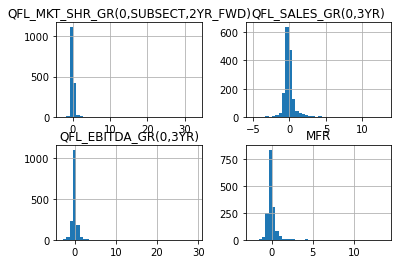

In [45]:
qfl_mfr_RFE.hist(bins = int(np.sqrt(len(qfl_mfr_RFE['MFR']))));

In [46]:
# Check Infomation Coefficient: MFR (Components: RFE's Feature Selected, Z-Scored)

sp_corr_z_rfe, sp_pval_z_rfe = stats.spearmanr(-qfl_mfr_RFE['MFR'].replace(np.nan, 0), qfl_df['p_total_return'].replace(np.nan, 0))
print('Information Coefficient: {0}'.format(round(sp_corr_z_rfe,2)))
print('Information Coefficient (P-Value): {0}'.format(round(sp_pval_z_rfe,2)))

Information Coefficient: 0.01
Information Coefficient (P-Value): 0.7


# Information Coefficient Summary (LVRB)

### Feature Selection: Recoursive Feature Elimination (RFE + Lasso) (3 Top Components)

In [47]:
print('Information Coefficient: {0}'.format(round(sp_corr_z_rfe,2)))
print('Information Coefficient (P-Value): {0}'.format(round(sp_pval_z_rfe,2)))

Information Coefficient: 0.01
Information Coefficient (P-Value): 0.7


### Z-Score + Log-Transformation (All Components)

In [48]:
print('Information Coefficient: {0}'.format(round(sp_corr_z_log,2)))
print('Information Coefficient (P-Value): {0}'.format(round(sp_pval_z_log,2)))

Information Coefficient: -0.05
Information Coefficient (P-Value): 0.03


### Z-Score Only (All Components)

In [49]:
print('Information Coefficient: {0}'.format(round(sp_corr_z,2)))
print('Information Coefficient (P-Value): {0}'.format(round(sp_pval_z,2)))

Information Coefficient: 0.05
Information Coefficient (P-Value): 0.07
